In [3]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from IPython.display import display, display_html, display_markdown, HTML, Markdown as md
from matplotlib.lines import Line2D
import seaborn as sns
import math
import time
import pickle
from joblib import dump

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize, normalize
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

In [25]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

# **Clasification Model Comparison Template** 

This Notebook compares the performance of different types of classification models on a dataset provided by the user. It is meant to assist in the model selection process, helping users discern the most suitible classification technique for their dataset. Throughout the template there are global variables that the user must configure which represent characteristics of the dataset. Unchanging characteristics like the name of the data file are represented with capitalized constant variables. Users should store data in the data directory.

## **Dataset Overview**
We'll be working with a customer segmentation dataset from Kaggle. The function of this dataset is to classify customers into different segments based on their characteristics. The dataset contains customer information including demographic data and purchasing behavior. Our target variable is 'Segmentation', which categorizes customers into segments A, B, C, or D.

## **Load in a Dataset and Select Columns to Drop**

In [19]:
DATA_FILE_NAME: str = "classification_segmentation_data.csv" 
COLUMNS_TO_DROP: list[str] = ["ID"] 

def display_dataframe(df: pd.DataFrame, font_size: int = 20) -> None:
    """
    Displays the passed in DataFrame with the specified font size.

    Args:
        df (pd.DataFrame): The DataFrame to be displayed.
        font_size (int): The font size at which the DataFrame should be displayed.

    Returns:
        None
    """
    # Convert the DataFrame to HTML
    df_html = df.to_html()
    # Apply the font size directly to the HTML
    styled_html = f'<div style="font-size: {font_size}px;">{df_html}</div>'
    display_html(HTML(styled_html))
    

def display_text(text: str, font_size: int = 16, font_weight: str = 'normal') -> None:
    """
    Displays the passed in text with the specified font size and font weight.

    Args:
        text (str): The text to be displayed.
        font_size (int): The font size at which the text should be displayed.
        font_weight (str): The font weight (e.g., 'normal', 'bold', 'bolder', 'lighter', or numeric value from 100 to 900).

    Returns:
        None
    """
    # Apply the font size and font weight directly to the HTML
    styled_html = f'<div style="font-size: {font_size}px; font-weight: {font_weight};">{text}</div>'
    display_html(HTML(styled_html))
    

def load_data(file_name: str = DATA_FILE_NAME, dropped_columns = COLUMNS_TO_DROP) -> pd.DataFrame:
    """
    Loads in user's input file as a pandas DataFrame.
    
    Args:
        file_name (str): Name of file containing data for clustering
        dropped_columns (list[str]): List of columns to drop from the dataframe
    Returns:
        pd.DataFrame: Dataframe of variable values for all data entries
    """
    
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format or misspelled file name. Please upload a CSV, Excel, or JSON file and ensure the file name is spelled correctly.")
    
    df.drop_duplicates(inplace = True)
    df.drop(columns = dropped_columns, inplace = True)
    
    return df


data_df = load_data()
initial_number_of_entries, number_of_variables = data_df.shape

numerical_variables: list[str] = list(data_df.select_dtypes(include = np.number).columns)
categorical_variables: list[str] = list(data_df.select_dtypes(exclude = np.number).columns)

# Convert all categorical columns to Catagorical type
data_df[categorical_variables] = data_df[categorical_variables].astype("category")

# Generate a report for the entire dataset
initial_dataset_profile = ProfileReport(data_df, title = "Dataset Profiling Report (Before Preprocessing)", progress_bar = False, explorative = True)
initial_dataset_profile.to_notebook_iframe()

### **Dataset Missing Values Information**

In [18]:
display_text(f"Numerical Variables: {numerical_variables}")
display_text(f"Categorical Variables: {categorical_variables}")

# Automatically select columns with missing values
numerical_variables_with_missing_values: list[str] = data_df[numerical_variables].columns[data_df[numerical_variables].isnull().any()].tolist()
categorical_variables_with_missing_values: list[str] = data_df[categorical_variables].columns[data_df[categorical_variables].isnull().any()].tolist()

variables_with_missing_values: list[str] = numerical_variables_with_missing_values + categorical_variables_with_missing_values

if len(variables_with_missing_values) != 0:
    print()
    entries_with_missing_values_df: pd.DataFrame = data_df[variables_with_missing_values][data_df[variables_with_missing_values].isnull().any(axis = "columns")]
    number_of_entries_with_missing_values: int = len(entries_with_missing_values_df)
    percent_of_entries_with_missing_values: float = (number_of_entries_with_missing_values / initial_number_of_entries) * 100  
    
    display_text(f"Total Number of Entries: {initial_number_of_entries}")
    display_text(f"Total Number of Entreis with at Least One Missing Value: {number_of_entries_with_missing_values} ({percent_of_entries_with_missing_values:.2f}% of Entries)")
    display_text(f"Number of Entries if all Rows with Missing Values are Dropped: {initial_number_of_entries - number_of_entries_with_missing_values}")
    print()
    display_text("Up to First 5 Entries with Missing Values:")
    display_dataframe(entries_with_missing_values_df.head(), font_size = 16)
else:
    print()
    display_text("No Missing Values in Dataset")

Numerical Variables: ['Age', 'Work_Experience', 'Family_Size']

Categorical Variables: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']

Total Number of Entries: 8068

Total Number of Entreis with at Least One Missing Value: 1403 (17.39% of Entries)

Number of Entries if all Rows with Missing Values are Dropped: 6665

Up to First 5 Entries with Missing Values:

Work_Experience 
 Family_Size 
 Ever_Married 
 Graduated 
 Profession 
 Var_1 
 
 
 
 
 1 
 NaN 
 3.0 
 Yes 
 Yes 
 Engineer 
 Cat_4 
 
 
 4 
 NaN 
 6.0 
 Yes 
 Yes 
 Entertainment 
 Cat_6 
 
 
 12 
 0.0 
 NaN 
 No 
 No 
 Executive 
 Cat_3 
 
 
 13 
 NaN 
 1.0 
 Yes 
 No 
 Lawyer 
 Cat_6 
 
 
 24 
 1.0 
 3.0 
 NaN 
 No 
 Executive 
 Cat_3

## **Handle Missing Values**
### Chose between dropping or imputing missing values.
If you chose to impute missing values, edit the imputute_missing_values function to suite your use case (such as choosing columns to impute and specifying between imputing with the mean, median, or mode of the column). The given imputute_missing_values function is applied to all columns with missing values. Missing numerical values are imputed with the median of the column and missing categorical values are imputed with the mode of the column.

In [20]:
def drop_rows_with_missing_values(df: pd.DataFrame = data_df) -> pd.DataFrame:
    """
    Drops all rows with missing values from the DataFrame and splits dataset into feature dataframe and target series.
    Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Args:
        df (pd.DataFrame): DataFrame containing loded in data
        target_variable_comlumn (str): Name of the target variable column
    Returns:
        pd.DataFrame: DataFrame with missing values dropped
    """
    
    original_number_of_entries = len(df)
    dropna_df = df.dropna()
    new_number_of_entries = len(dropna_df)
    number_of_entries_dropped = original_number_of_entries - new_number_of_entries
    
    display_markdown(md(f"### drop_rows_with_missing_values Results: {number_of_entries_dropped} Entries Dropped"))
    display_markdown(md(f"### New Number of Entries: {new_number_of_entries}"))
    
    return dropna_df


def impute_missing_values(df: pd.DataFrame = data_df,
                          numerical_columns_to_impute: list[str] = numerical_variables_with_missing_values,
                          categorical_columns_to_impute: list[str] = categorical_variables_with_missing_values) -> pd.DataFrame:
    """
    Imputes missing values in the DataFrame with either the median value (for numerical features) or the most frequent value (for categorical features)
    and splits dataset into feature dataframe and target series. Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Args:
        df (pd.DataFrame): DataFrame containing loded in data.
        target_variable_column (str): Name of the target variable column
    Returns:
        impute_df (pd.DataFrame): DataFrame with missing values imputed
    """
    impute_df = df.copy()
    
    numerical_imputer = SimpleImputer(strategy = "median")
    categorical_imputer = SimpleImputer(strategy = "most_frequent")
    
    impute_df[numerical_columns_to_impute] = numerical_imputer.fit_transform(impute_df[numerical_columns_to_impute])
    impute_df[categorical_columns_to_impute] = categorical_imputer.fit_transform(impute_df[categorical_columns_to_impute])
    
    display_markdown(md("### Missing Values Imputed"))
    
    return impute_df


data_df = drop_rows_with_missing_values()

print()
display_text("Numerical Variables Information", font_size = 22, font_weight = 'bold')
display_dataframe(data_df.describe(), 16) 
print()

### drop_rows_with_missing_values Results: 1403 Entries Dropped

### New Number of Entries: 6665

Numerical Variables Information

Age 
 Work_Experience 
 Family_Size 
 
 
 
 
 count 
 6665.000000 
 6665.000000 
 6665.000000 
 
 
 mean 
 43.536084 
 2.629107 
 2.841110 
 
 
 std 
 16.524054 
 3.405365 
 1.524743 
 
 
 min 
 18.000000 
 0.000000 
 1.000000 
 
 
 25% 
 31.000000 
 0.000000 
 2.000000 
 
 
 50% 
 41.000000 
 1.000000 
 2.000000 
 
 
 75% 
 53.000000 
 4.000000 
 4.000000 
 
 
 max 
 89.000000 
 14.000000 
 9.000000

## **Handle Outliers/Eronious Entries**

In [7]:
%matplotlib inline

def visualize_outliers(df: pd.DataFrame,
                       columns_to_check: list[str] = None,
                       iqr_multiplier: float = 1.5,
                       remove: bool = False,
                       remove_option: str = 'both',
                       display: bool = True,) -> pd.DataFrame:
    """
    Creates a boxplot-  for the columns in the input DataFrame (df) given by columns_to_check. Calculates outliers using the interquartile range (IQR) method
    and gives users the option to remove 
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        iqr_multiplier (float): Multiplier for the interquartile range to define outliers
        columns_to_check (list[str]): List of columns to check for outliers. If None, all numerical columns will be checked.
        remove (bool): If True, returns a DataFrame with outliers removed.
        remove_option (str): Option to remove 'both', 'upper', or 'lower' outliers.
        display (bool): If True, displays boxplots of each column with outliers and their lower and upper bounds.
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed if remove is True, otherwise the original DataFrame
    """
    if columns_to_check == None:
        columns_to_check = df.select_dtypes(include=[np.number]).columns
    
    outlier_indices = set()
    
    for col in columns_to_check:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr
        
        if display:
            plt.figure(figsize=(10, 6))
            ax = sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
            
            # Add vertical red dotted lines for lower and upper bounds if within the plot's x-axis limits
            x_min, x_max = ax.get_xlim()
            if x_min <= lower_bound <= x_max:
                plt.axvline(lower_bound, color='red', linestyle='dotted', linewidth=1)
            if x_min <= upper_bound <= x_max:
                plt.axvline(upper_bound, color='red', linestyle='dotted', linewidth=1)
            
            # Create legend
            legend_lines = [Line2D([0], [0], color='red', linestyle='dotted', linewidth=1)]
            legend_labels = ['Lower/Upper Bound']
            plt.legend(legend_lines, legend_labels, loc='upper right')
            
            plt.show()
        
            display_text(f"{col}:", font_size = 18, font_weight = 'bold')
            display_text(f"- Lower Bound for Outliers: {lower_bound}", font_size = 16)
            display_text(f"- Upper Bound for Outliers: {upper_bound}", font_size = 16)
            display_text(f"- Number of Outliers Below Lower Bound: {df[col][df[col] < lower_bound].count()}", font_size = 16)
            display_text(f"- Number of Outliers Above Upper Bound: {df[col][df[col] > upper_bound].count()}", font_size = 16)
            print()
        
        
        if remove_option in ['both', 'lower']:
            outlier_indices.update(df.index[df[col] < lower_bound].tolist())
        if remove_option in ['both', 'upper']:
            outlier_indices.update(df.index[df[col] > upper_bound].tolist())
    
    if remove:
        df_cleaned = df.drop(index=outlier_indices)
        display_text(f"Total Number of Outlier Entries Removed in {col}: {(len(outlier_indices))}", font_size = 18)
        print()
        return df_cleaned
    
    return df
    
data_df = visualize_outliers(data_df, display = False)

## **Setup Preprocessing**

### **Dataset Preprocessing Information**
#### Displays information that helps users setup their preprocessing steps.

In [21]:
display_text(f"Numerical Variables: {numerical_variables}")
display_text(f"Categorical Variables: {categorical_variables}")

if len(categorical_variables) != 0:
    print()
    display_text(f"Unique Entries for Categorical Variables:")
    
    for variable in categorical_variables:
        unique_entries = list(data_df[variable].unique())
        display_markdown(md(f"* {variable} Variable: {unique_entries}"))

Numerical Variables: ['Age', 'Work_Experience', 'Family_Size']

Categorical Variables: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']

Unique Entries for Categorical Variables:

* Gender Variable: ['Male', 'Female']

* Ever_Married Variable: ['No', 'Yes']

* Graduated Variable: ['No', 'Yes']

* Profession Variable: ['Healthcare', 'Engineer', 'Lawyer', 'Artist', 'Doctor', 'Homemaker', 'Entertainment', 'Marketing', 'Executive']

* Spending_Score Variable: ['Low', 'High', 'Average']

* Var_1 Variable: ['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', 'Cat_5']

* Segmentation Variable: ['D', 'B', 'C', 'A']

### **Preprocessing Steps**
Edit the preprocessing steps to suit your dataset. The preprocessing steps for the feature dataframe are composed with the make_pipeline function to load in models, so combine them with a function such as ColumnTransformer to create a single preprocessing variable.

Preprocessing for the target series must be done separately from the feature dataframe. The target preprocessing steps will be applied directly to the y_train and y_test sets when splits are created.

In [69]:
TARGET_COLUMN_NAME: str = "Segmentation"


numerical_features_to_scale: list[str] = list(set(numerical_variables) - set([TARGET_COLUMN_NAME]))
nominal_categorical_features_to_encode: list[str] = list(set(categorical_variables) - set([TARGET_COLUMN_NAME]))

# Order ordinal variable categories from lowest to highest 
ordianl_categories_ordered_dict: dict[str, list[str]] = {
    "Spending_Score": ['Low', 'Average', 'High']
}
ordianl_features_categories_to_encode: list[str] = list(ordianl_categories_ordered_dict.keys())
ordianl_features_categories_orders_lists: list[list[str]] = list(ordianl_categories_ordered_dict.values())

# Indicates that the first column of one-hot encoded variables should be dropped to avoid multicollinearity
onehot_drop_column = "first"


# Pass in a list of tuples containing a name for the transformer (decide a name, allows transformer parameters to be searched in grid search),
# the transformer object, and the columns to apply the transformer to
general_feature_preprocessor = ColumnTransformer(
    transformers = [
        ('numerical_scaler', StandardScaler(), numerical_features_to_scale),
        ('nominal_encoder', OneHotEncoder(drop = onehot_drop_column), nominal_categorical_features_to_encode),
        ("ordinal_encoder", OrdinalEncoder(categories = ordianl_features_categories_orders_lists), ordianl_features_categories_to_encode)
    ]
)

# Setup target preprocessor
nominal_target_preprocessor = LabelEncoder()

display_markdown(md(f"### **Scaled Numerical Features:** {numerical_features_to_scale}"))
display_markdown(md(f"### **Encoded Nominal Categorical Features:** {nominal_categorical_features_to_encode}"))
display_markdown(md(f"### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**"))
for i in range(len(ordianl_features_categories_to_encode)):
    display_markdown(md(f"* #### **{ordianl_features_categories_to_encode[i]}:** {ordianl_features_categories_orders_lists[i]}"))

### **Scaled Numerical Features:** ['Age', 'Work_Experience', 'Family_Size']

### **Encoded Nominal Categorical Features:** ['Profession', 'Spending_Score', 'Gender', 'Var_1', 'Ever_Married', 'Graduated']

### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**

* #### **Spending_Score:** ['Low', 'Average', 'High']

In [133]:
TARGET_COLUMN_NAME: str = "GradeClass"


numerical_features_to_scale: list[str] = ["Age", "StudyTimeWeekly", "Absences", ]
nominal_categorical_features_to_encode: list[str] = ["Ethnicity"]

# Order ordinal variable categories from lowest to highest 
ordianl_categories_ordered_dict: dict[str, list[str]] = {
    "ParentalEducation": [0, 1, 2, 3, 4],
    "ParentalSupport": [0, 1, 2, 3, 4]
}
ordianl_features_categories_to_encode: list[str] = list(ordianl_categories_ordered_dict.keys())
ordianl_features_categories_orders_lists: list[list[str]] = list(ordianl_categories_ordered_dict.values())

# Indicates that the first column of one-hot encoded variables should be dropped to avoid multicollinearity
onehot_drop_column = "first"


# Pass in a list of tuples containing a name for the transformer (decide a name, allows transformer parameters to be searched in grid search),
# the transformer object, and the columns to apply the transformer to
general_feature_preprocessor = ColumnTransformer(
    transformers = [
        ('numerical_scaler', StandardScaler(), numerical_features_to_scale),
        ('nominal_encoder', OneHotEncoder(drop = onehot_drop_column), nominal_categorical_features_to_encode),
        ("ordinal_encoder", OrdinalEncoder(categories = ordianl_features_categories_orders_lists), ordianl_features_categories_to_encode)
    ]
)

# Setup target preprocessor
nominal_target_preprocessor = LabelEncoder()

display_markdown(md(f"### **Scaled Numerical Features:** {numerical_features_to_scale}"))
display_markdown(md(f"### **Encoded Nominal Categorical Features:** {nominal_categorical_features_to_encode}"))
display_markdown(md(f"### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**"))
for i in range(len(ordianl_features_categories_to_encode)):
    display_markdown(md(f"* #### **{ordianl_features_categories_to_encode[i]}:** {ordianl_features_categories_orders_lists[i]}"))

### **Scaled Numerical Features:** ['Age', 'StudyTimeWeekly', 'Absences']

### **Encoded Nominal Categorical Features:** ['Ethnicity']

### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**

* #### **ParentalEducation:** [0, 1, 2, 3, 4]

* #### **ParentalSupport:** [0, 1, 2, 3, 4]

## **Load In Models and Set Hyperparameters**
Define the functions for loading each model. Use the make_pipeline function to combine the preprocessing steps with the model and set the hyperparameters for each model to be optimized by GridSearchCV.

The make_pipeline function changes the way you have to input values in each models param_grid. In order for GridSearchCV to work with the make_pipline function, model hyeperparameter keys must be prefixed with the model name followed by two underscores (ex: the hyperparameter for the Lasso Regression model is "lasso__alpha" instead of just "alpha").

In [131]:
def load_logistic_regression_model() -> dict[str, dict]:
    model_data = {
        'Logistic Regression': {
            'model': make_pipeline(general_feature_preprocessor, LogisticRegression(max_iter=1000)),
            'param_grid': {
                'logisticregression__C': [0.1, 1, 10],
                'logisticregression__solver': ['liblinear', 'saga']
            }
        }
    }
    return model_data

def load_knn_model() -> dict[str, dict]:
    model_data = {
        'KNN': {
            'model': make_pipeline(general_feature_preprocessor, KNeighborsClassifier()),
            'param_grid': {
                'kneighborsclassifier__n_neighbors': [3, 5, 7],
                'kneighborsclassifier__weights': ['uniform', 'distance']
            }
        }
    }
    return model_data

def load_decision_tree_model() -> dict[str, dict]:
    model_data = {
        'Decision Tree': {
            'model': make_pipeline(general_feature_preprocessor, DecisionTreeClassifier(random_state=42)),
            'param_grid': {
                'decisiontreeclassifier__max_depth': [None, 5, 10],
                'decisiontreeclassifier__min_samples_split': [2, 5, 10]
            }
        }
    }
    return model_data

def load_random_forest_model() -> dict[str, dict]:
    model_data = {
        'Random Forest': {
            'model': make_pipeline(general_feature_preprocessor, RandomForestClassifier(random_state=42)),
            'param_grid': {
                'randomforestclassifier__n_estimators': [100, 200],
                'randomforestclassifier__max_depth': [None, 5, 10]
            }
        }
    }
    return model_data

def load_svc_model() -> dict[str, dict]:
    model_data = {
        'SVC': {
            'model': make_pipeline(general_feature_preprocessor, SVC(probability=True, random_state=42)),
            'param_grid': {
                'svc__C': [0.1, 1, 10],
                'svc__kernel': ['linear', 'rbf']
            }
        }
    }
    return model_data

def load_naive_bayes_model() -> dict[str, dict]:
    model_data = {
        'Naive Bayes': {
            'model': make_pipeline(general_feature_preprocessor, GaussianNB()),
            'param_grid': {}
        }
    }
    return model_data


## **Model Training and Evaluation**
#### Assign each model to a variable and use the unpacking operator (**) to place each model in a dictionary. The keys of the dictionary should be model names and the values should be model hyperparameters.
#### Split the data into training and testing sets using the train_test_split function and transform the target variable using your target preprocessing steps. After this, the train_and_evaluate_models function will have access to all of it's necessary variables.
#### The train_and_evaluate_models function uses GridSearchCV to optimize the model hyperparameters. The resulting best model is then trained and evaluated. The function also saves necessary data for model visualisations.

In [147]:
NUM_DECIMAL_PLACES: int = 7 # Determines the number of decimal places to display for model evaluation metrics

# Load all models
logistic_regression_model = load_logistic_regression_model()
knn_model = load_knn_model()
decision_tree_model = load_decision_tree_model()
random_forest_model = load_random_forest_model()
svc_model = load_svc_model()
naive_bayes_model = load_naive_bayes_model()

models = {
    **logistic_regression_model,
    **knn_model,
    **decision_tree_model,
    **random_forest_model,
    **svc_model,
    **naive_bayes_model
}

X = data_df.drop(columns = [TARGET_COLUMN_NAME])
y = data_df[TARGET_COLUMN_NAME]

FEATURE_LIST = list(X.columns)
NUM_FEATURES: int = len(FEATURE_LIST)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_train = nominal_target_preprocessor.fit_transform(y_train)
y_test = nominal_target_preprocessor.fit_transform(y_test)

def train_and_evaluate_models(models_dict: dict[dict[str, dict]] = models,
                              X_train: pd.DataFrame = X_train,
                              X_test: pd.DataFrame = X_test,
                              y_train: np.ndarray = y_train,
                              y_test: np.ndarray = y_test) -> dict:
    """
    Optimizes the hyperparameters of, trains, and evaluates the performance of all passed in models on the training and testing data.
    Also saves information from the training process such as best model, predictions, and training/testing time.
    
    Args:
        models_dict (dict[dict[str, dict]]): Dictionary containing model names as keys and dictionaries containing the model object and hyperparameter grid as values
        X_train (pd.DataFrame): DataFrame containing feature variable values for training the models
        X_test (pd.DataFrame): DataFrame containing feature variable values for testing the models
        y_train (np.ndarray): 1D np.ndarray containing target variable values for training the models
        y_test (np.ndarray): 1D np.ndarray containing target variable values for testing the models
    Returns:
        model_results (dict): Dictionary that has model names as its keys. The value for these keys are dictionaries containing the trained model object,
        model predictions on the testing data, and other data from the training process such as accuracy, precision, recall, and F1 scores.
    """
    
    model_results = {}
    
    for model_name, model_data in models_dict.items():
        display_markdown(md(f"### **Training and evaluating: {model_name}**"))
        
        model = model_data['model']
        param_grid = model_data['param_grid']
        
        stratifiedkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(model, param_grid, cv=stratifiedkf, scoring='accuracy')
        
        tune_train_start_time = time.time()
        grid_search.fit(X_train, y_train)
        tune_train_end_time = time.time()
        tune_train_time = tune_train_end_time - tune_train_start_time
        display_markdown(md(f"* #### **Hyperparameter Tuning and Model Training Time:** {tune_train_time:.2f} seconds"))
        
        best_model = grid_search.best_estimator_
        
        y_train_predictions = best_model.predict(X_train)
        y_test_predictions = best_model.predict(X_test)
        y_test_prediction_probabilities = best_model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_test_predictions)
        precision = precision_score(y_test, y_test_predictions, average='weighted')
        recall = recall_score(y_test, y_test_predictions, average='weighted')
        f1 = f1_score(y_test, y_test_predictions, average='weighted')
        
        display_markdown(md(f"* #### **Test Accuracy:** {accuracy:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test Precision:** {precision:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test Recall:** {recall:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test F1 Score:** {f1:.{NUM_DECIMAL_PLACES}f}"))
        
        model_results[model_name] = {
            'best_model': best_model,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            "cv_results": grid_search.cv_results_,
            "tune_train_time": tune_train_time,
            "y_train_predictions": y_train_predictions,
            "y_test_predictions": y_test_predictions,
            "y_test_prediction_probabilities": y_test_prediction_probabilities,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
    
    return model_results

model_results = train_and_evaluate_models()

### **Training and evaluating: Logistic Regression**

* #### **Hyperparameter Tuning and Model Training Time:** 0.46 seconds

* #### **Test Accuracy:** 0.6659708

* #### **Test Precision:** 0.6219152

* #### **Test Recall:** 0.6659708

* #### **Test F1 Score:** 0.6359361

### **Training and evaluating: KNN**

* #### **Hyperparameter Tuning and Model Training Time:** 0.33 seconds

* #### **Test Accuracy:** 0.6137787

* #### **Test Precision:** 0.5809965

* #### **Test Recall:** 0.6137787

* #### **Test F1 Score:** 0.5932705

### **Training and evaluating: Decision Tree**

* #### **Hyperparameter Tuning and Model Training Time:** 0.34 seconds

* #### **Test Accuracy:** 0.6367432

* #### **Test Precision:** 0.6215795

* #### **Test Recall:** 0.6367432

* #### **Test F1 Score:** 0.6250797

### **Training and evaluating: Random Forest**

* #### **Hyperparameter Tuning and Model Training Time:** 5.73 seconds

* #### **Test Accuracy:** 0.6617954

* #### **Test Precision:** 0.6631739

* #### **Test Recall:** 0.6617954

* #### **Test F1 Score:** 0.6397976

### **Training and evaluating: SVC**

* #### **Hyperparameter Tuning and Model Training Time:** 5.51 seconds

/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* #### **Test Accuracy:** 0.6993737

* #### **Test Precision:** 0.6631010

* #### **Test Recall:** 0.6993737

* #### **Test F1 Score:** 0.6791633

### **Training and evaluating: Naive Bayes**

* #### **Hyperparameter Tuning and Model Training Time:** 0.05 seconds

* #### **Test Accuracy:** 0.6325678

* #### **Test Precision:** 0.6011749

* #### **Test Recall:** 0.6325678

* #### **Test F1 Score:** 0.6050481

### **Comparative Model Performance**

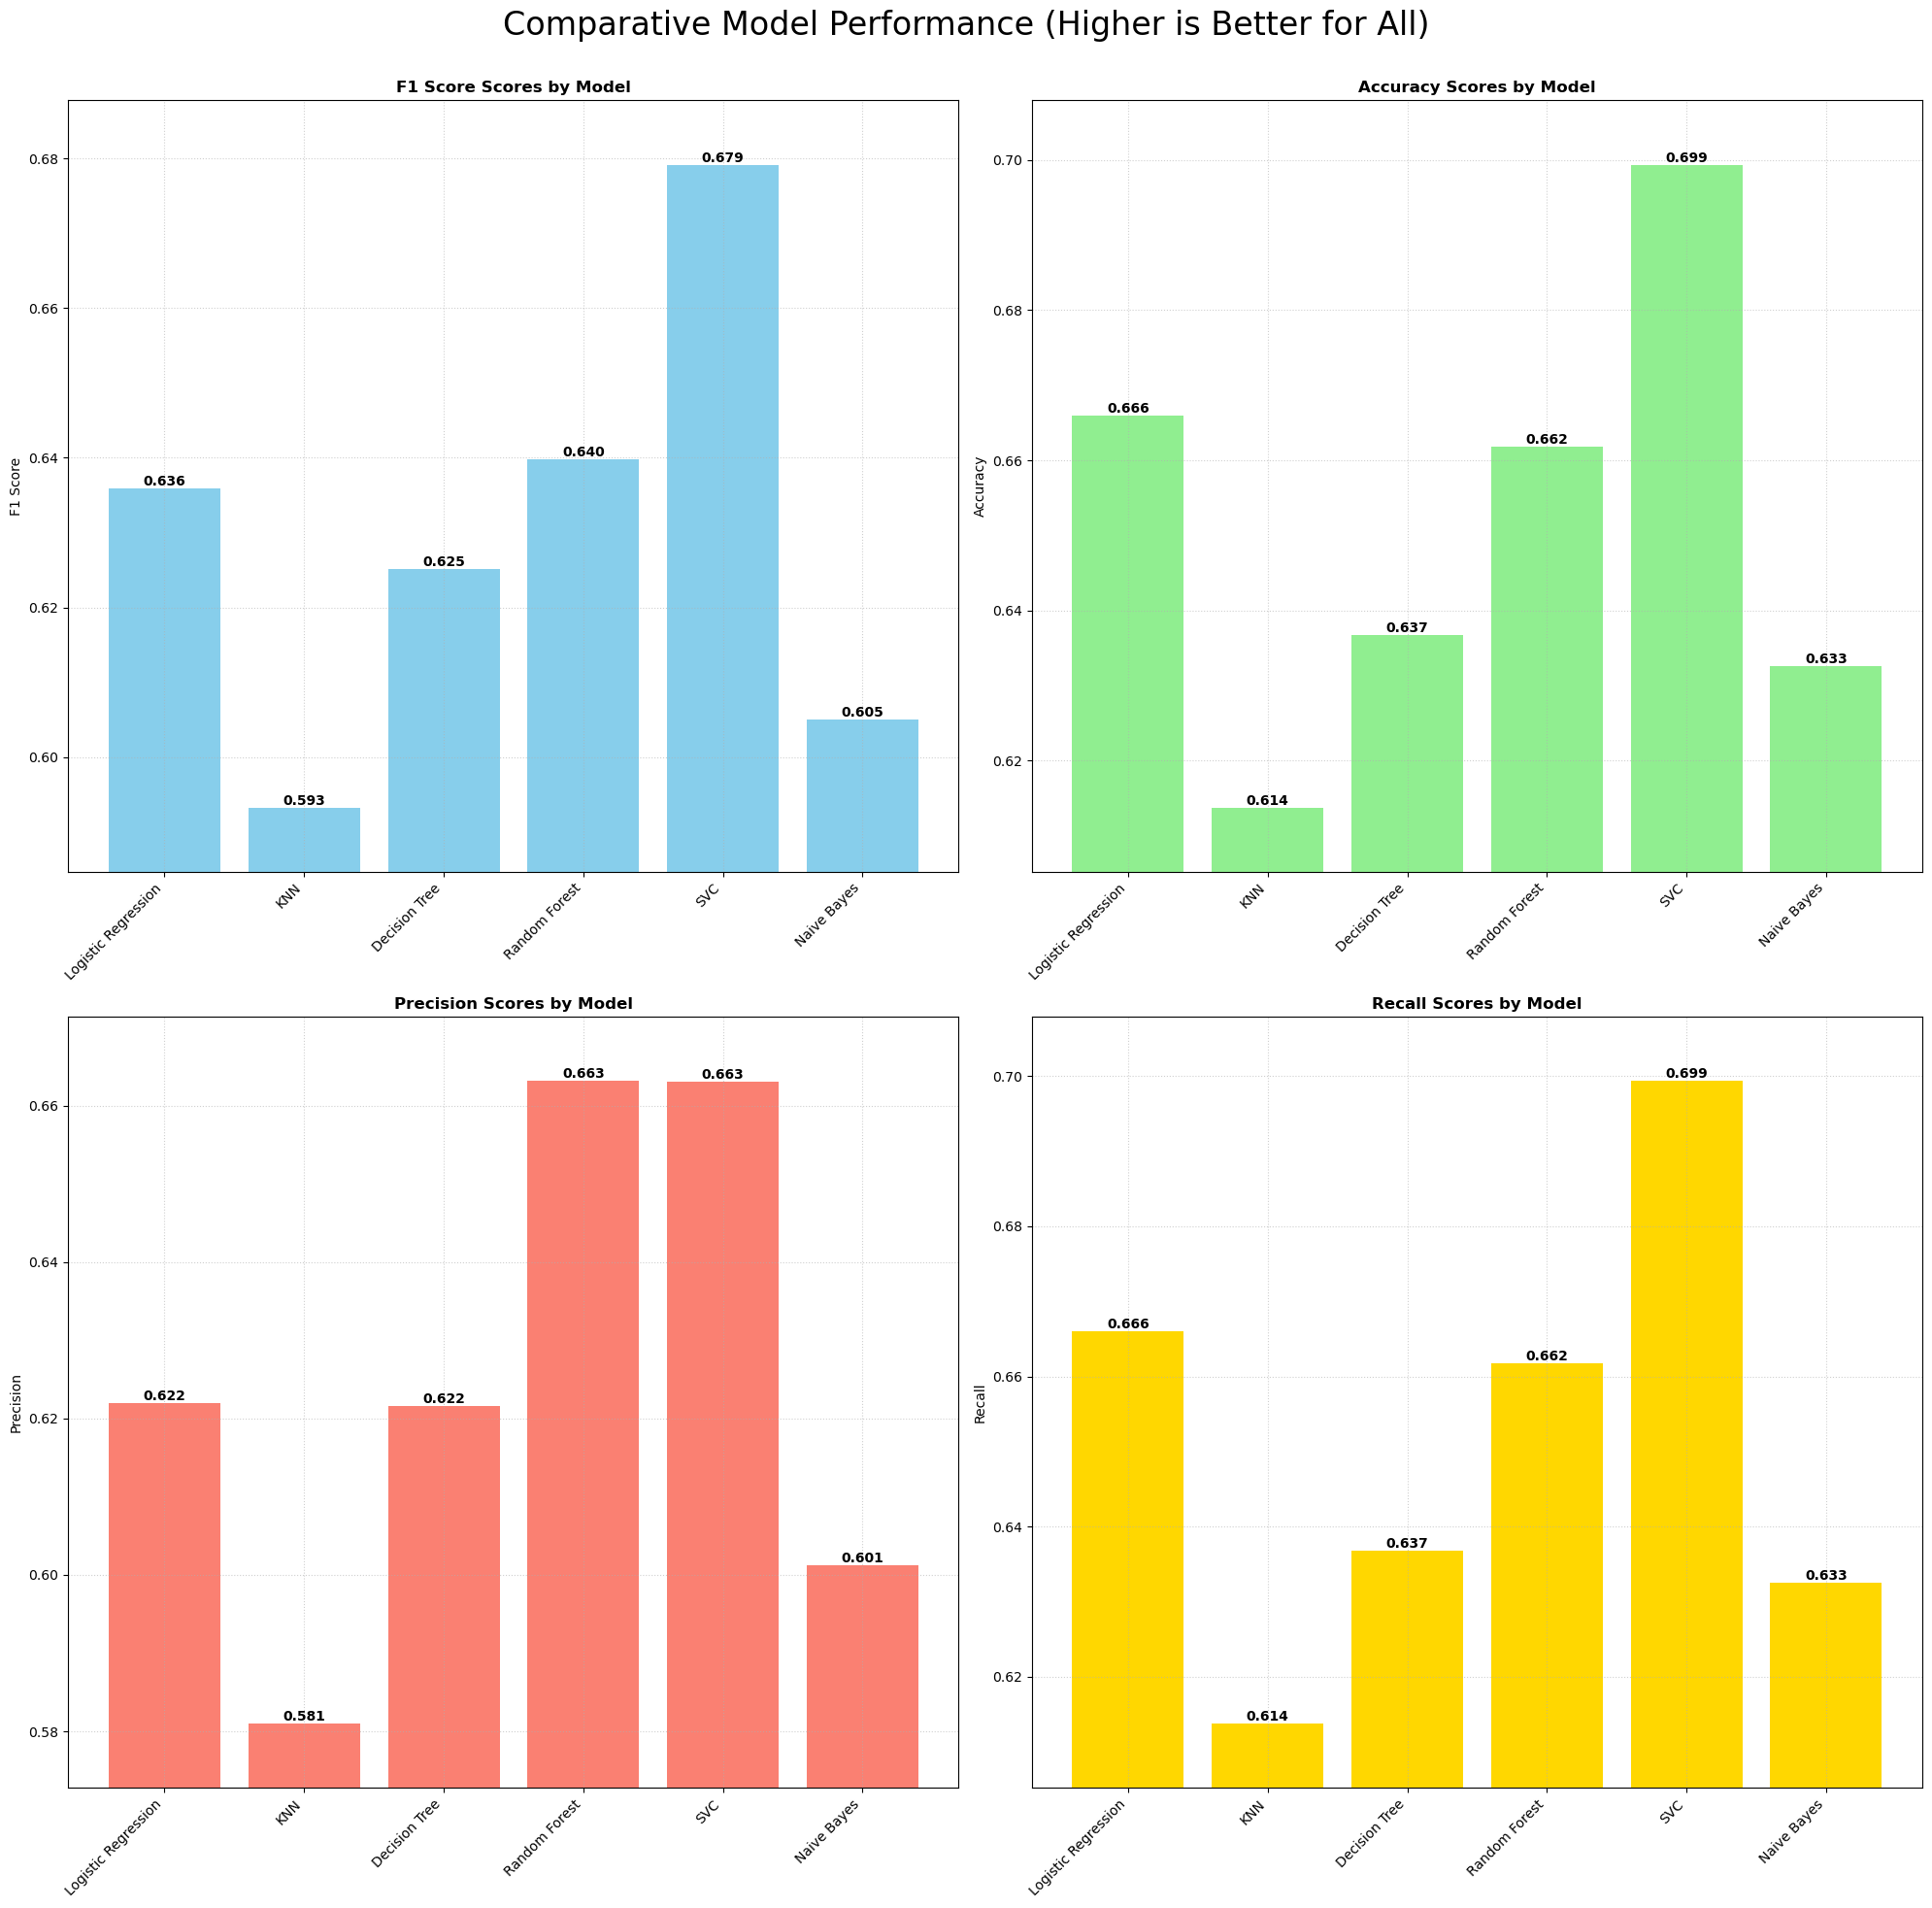

In [135]:
def plot_comparative_model_performance(model_results: dict[str, dict[str, object]]):
    """
    Creates a grouped bar chart to compare performance metrics across different classification models.

    Args:
    model_results (Dict[str, Dict[str, Any]]): Dictionary containing model names as keys and their results as values.
                                               Each model's results should include 'f1', 'accuracy', 'precision', and 'recall'.

    Returns:
    None
    """
    # Extract model names and metrics
    models = list(model_results.keys())

    # Prepare data for plotting
    f1_scores = [model_results[model]['f1'] for model in models]
    accuracy_scores = [model_results[model]['accuracy'] for model in models]
    precision_scores = [model_results[model]['precision'] for model in models]
    recall_scores = [model_results[model]['recall'] for model in models]

    # Set up the plot
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Comparative Model Performance (Higher is Better for All)', fontsize=24)
    
    # Add separation between the main title and subplots
    plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)

    # Function to plot metric and set y-axis limits
    def plot_metric(ax, scores, title, color):
        x = np.arange(len(models))  # the label locations
        ax.bar(x, scores, color=color)
        ax.set_ylabel(title)
        ax.set_title(f'{title} Scores by Model', fontweight='bold')
        
        # Set tick locations and labels
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        
        # Set y-axis limits relative to the scores
        min_score = min(scores)
        max_score = max(scores)
        range_score = max_score - min_score
        ax.set_ylim(max(0, min_score - 0.1 * range_score), min(1, max_score + 0.1 * range_score))
        
        # Add value labels on the bars
        for i, v in enumerate(scores):
            ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot F1 scores
    plot_metric(axs[0, 0], f1_scores, 'F1 Score', 'skyblue')
    
    # Plot Accuracy scores
    plot_metric(axs[0, 1], accuracy_scores, 'Accuracy', 'lightgreen')
    
    # Plot Precision scores
    plot_metric(axs[1, 0], precision_scores, 'Precision', 'salmon')
    
    # Plot Recall scores
    plot_metric(axs[1, 1], recall_scores, 'Recall', 'gold')

    # Add grid to all subplots
    for ax in axs.flat:
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.975])  # Add space at the top for the main title
    plt.show()


plot_comparative_model_performance(model_results)

### **Results Summary**

In [137]:
def summarize_results(results: dict = model_results):
    """
    Displays the performance metrics of all models trained and evaluated in the train_and_evaluate_models function in a DataFrame
    and returns the name of the best model based on accuracy score. The model with the highest accuracy score is considered the best model.

    Args:
        results (dict): Dictionary containing model names as keys and dictionaries containing the trained model object,
                        predictions on the testing data, accuracy, precision, recall, F1 score, and other model performance data as values
    Returns:
        best_performing_model (str): Name of the best model based on accuracy score
    """

    summary_df = pd.DataFrame({
        'Model': results.keys(),
        'F1 Score': [result['f1'] for result in results.values()],
        'Accuracy': [result['accuracy'] for result in results.values()],
        'Precision': [result['precision'] for result in results.values()],
        'Recall': [result['recall'] for result in results.values()]
    })

    display(md("## Model Performance Summary"))
    display_dataframe(summary_df)
    print()

    best_performing_model = summary_df.loc[summary_df['F1 Score'].idxmax(), 'Model']
    display(md(f"## **Best Performing Model: {best_performing_model}** (based on F1 score, the higher the better)"))
    display(md(f"* ### F1 Score: {results[best_performing_model]['f1']:.{NUM_DECIMAL_PLACES}f}"))
    display(md(f"* ### Accuracy Score: {results[best_performing_model]['accuracy']:.{NUM_DECIMAL_PLACES}f}"))
    display(md(f"* ### Precision Score: {results[best_performing_model]['precision']:.{NUM_DECIMAL_PLACES}f}"))
    display(md(f"* ### Recall Score: {results[best_performing_model]['recall']:.{NUM_DECIMAL_PLACES}f}"))

    return best_performing_model

best_model = summarize_results()

## Model Performance Summary

Model 
 F1 Score 
 Accuracy 
 Precision 
 Recall 
 
 
 
 
 0 
 Logistic Regression 
 0.635936 
 0.665971 
 0.621915 
 0.665971 
 
 
 1 
 KNN 
 0.593271 
 0.613779 
 0.580997 
 0.613779 
 
 
 2 
 Decision Tree 
 0.625080 
 0.636743 
 0.621580 
 0.636743 
 
 
 3 
 Random Forest 
 0.639798 
 0.661795 
 0.663174 
 0.661795 
 
 
 4 
 SVC 
 0.679163 
 0.699374 
 0.663101 
 0.699374 
 
 
 5 
 Naive Bayes 
 0.605048 
 0.632568 
 0.601175 
 0.632568

## **Best Performing Model: SVC** (based on F1 score, the higher the better)

* ### F1 Score: 0.6791633

* ### Accuracy Score: 0.6993737

* ### Precision Score: 0.6631010

* ### Recall Score: 0.6993737

### **Comparative Model Performance Visualizations**

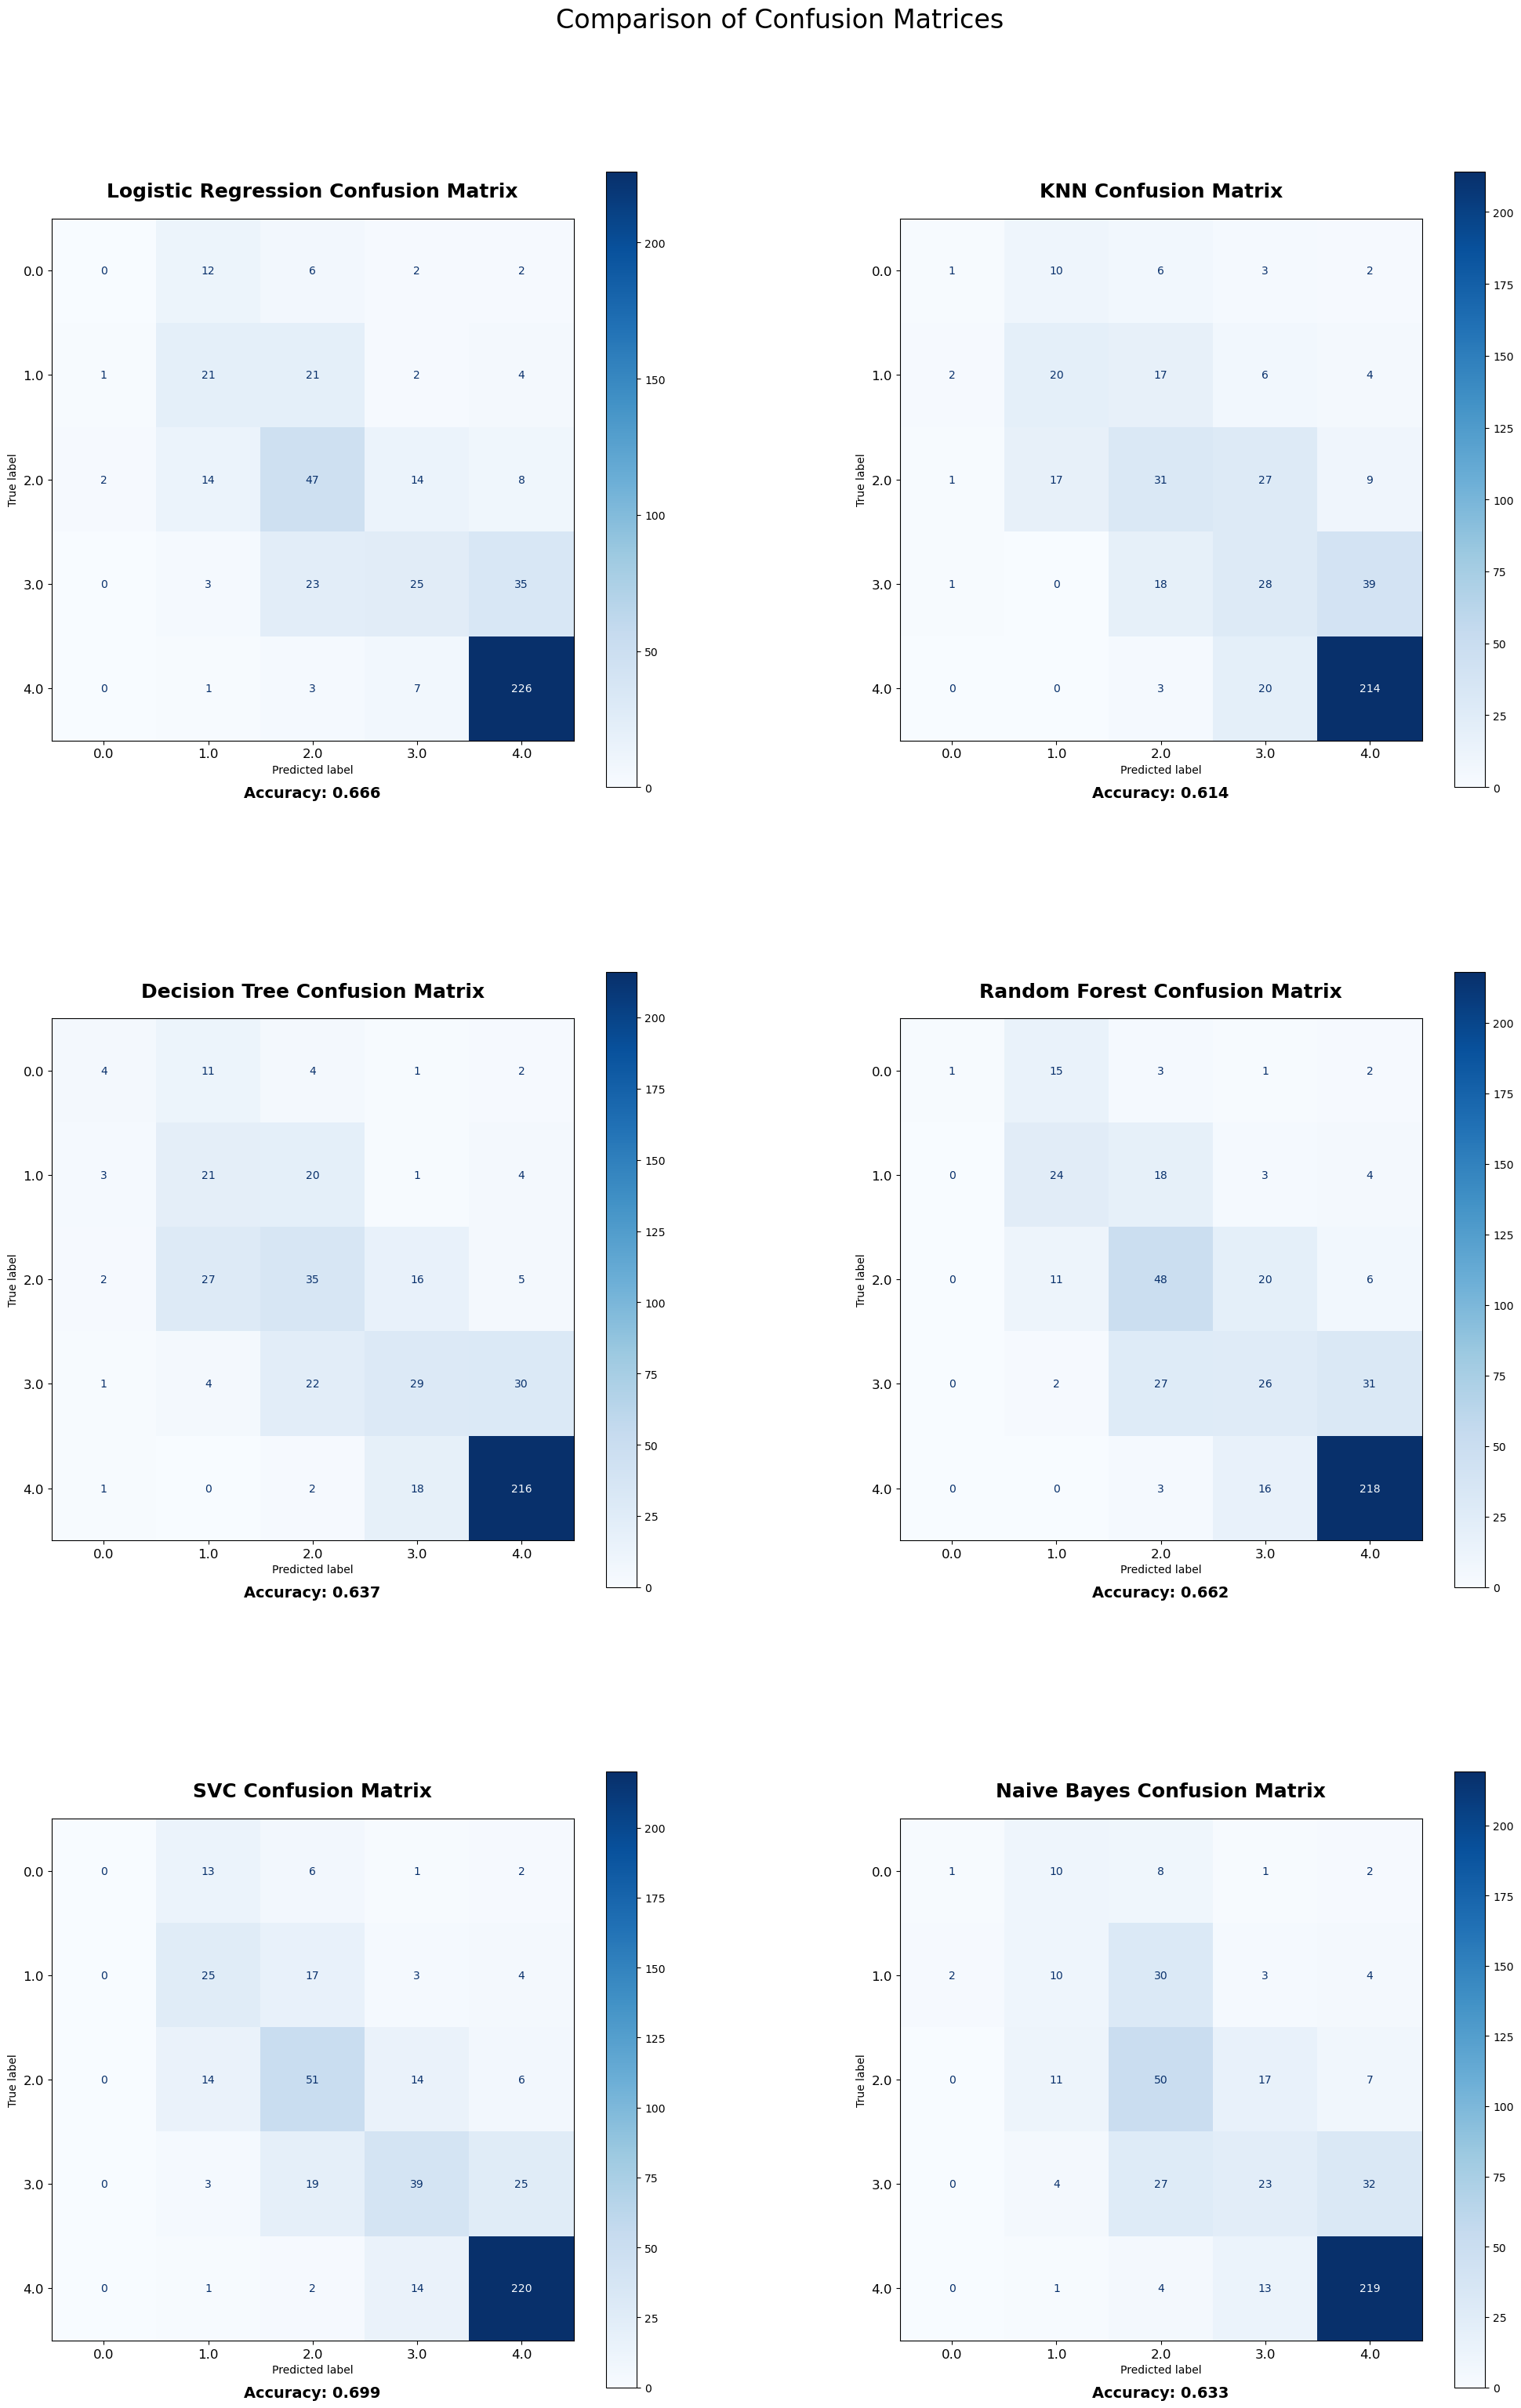

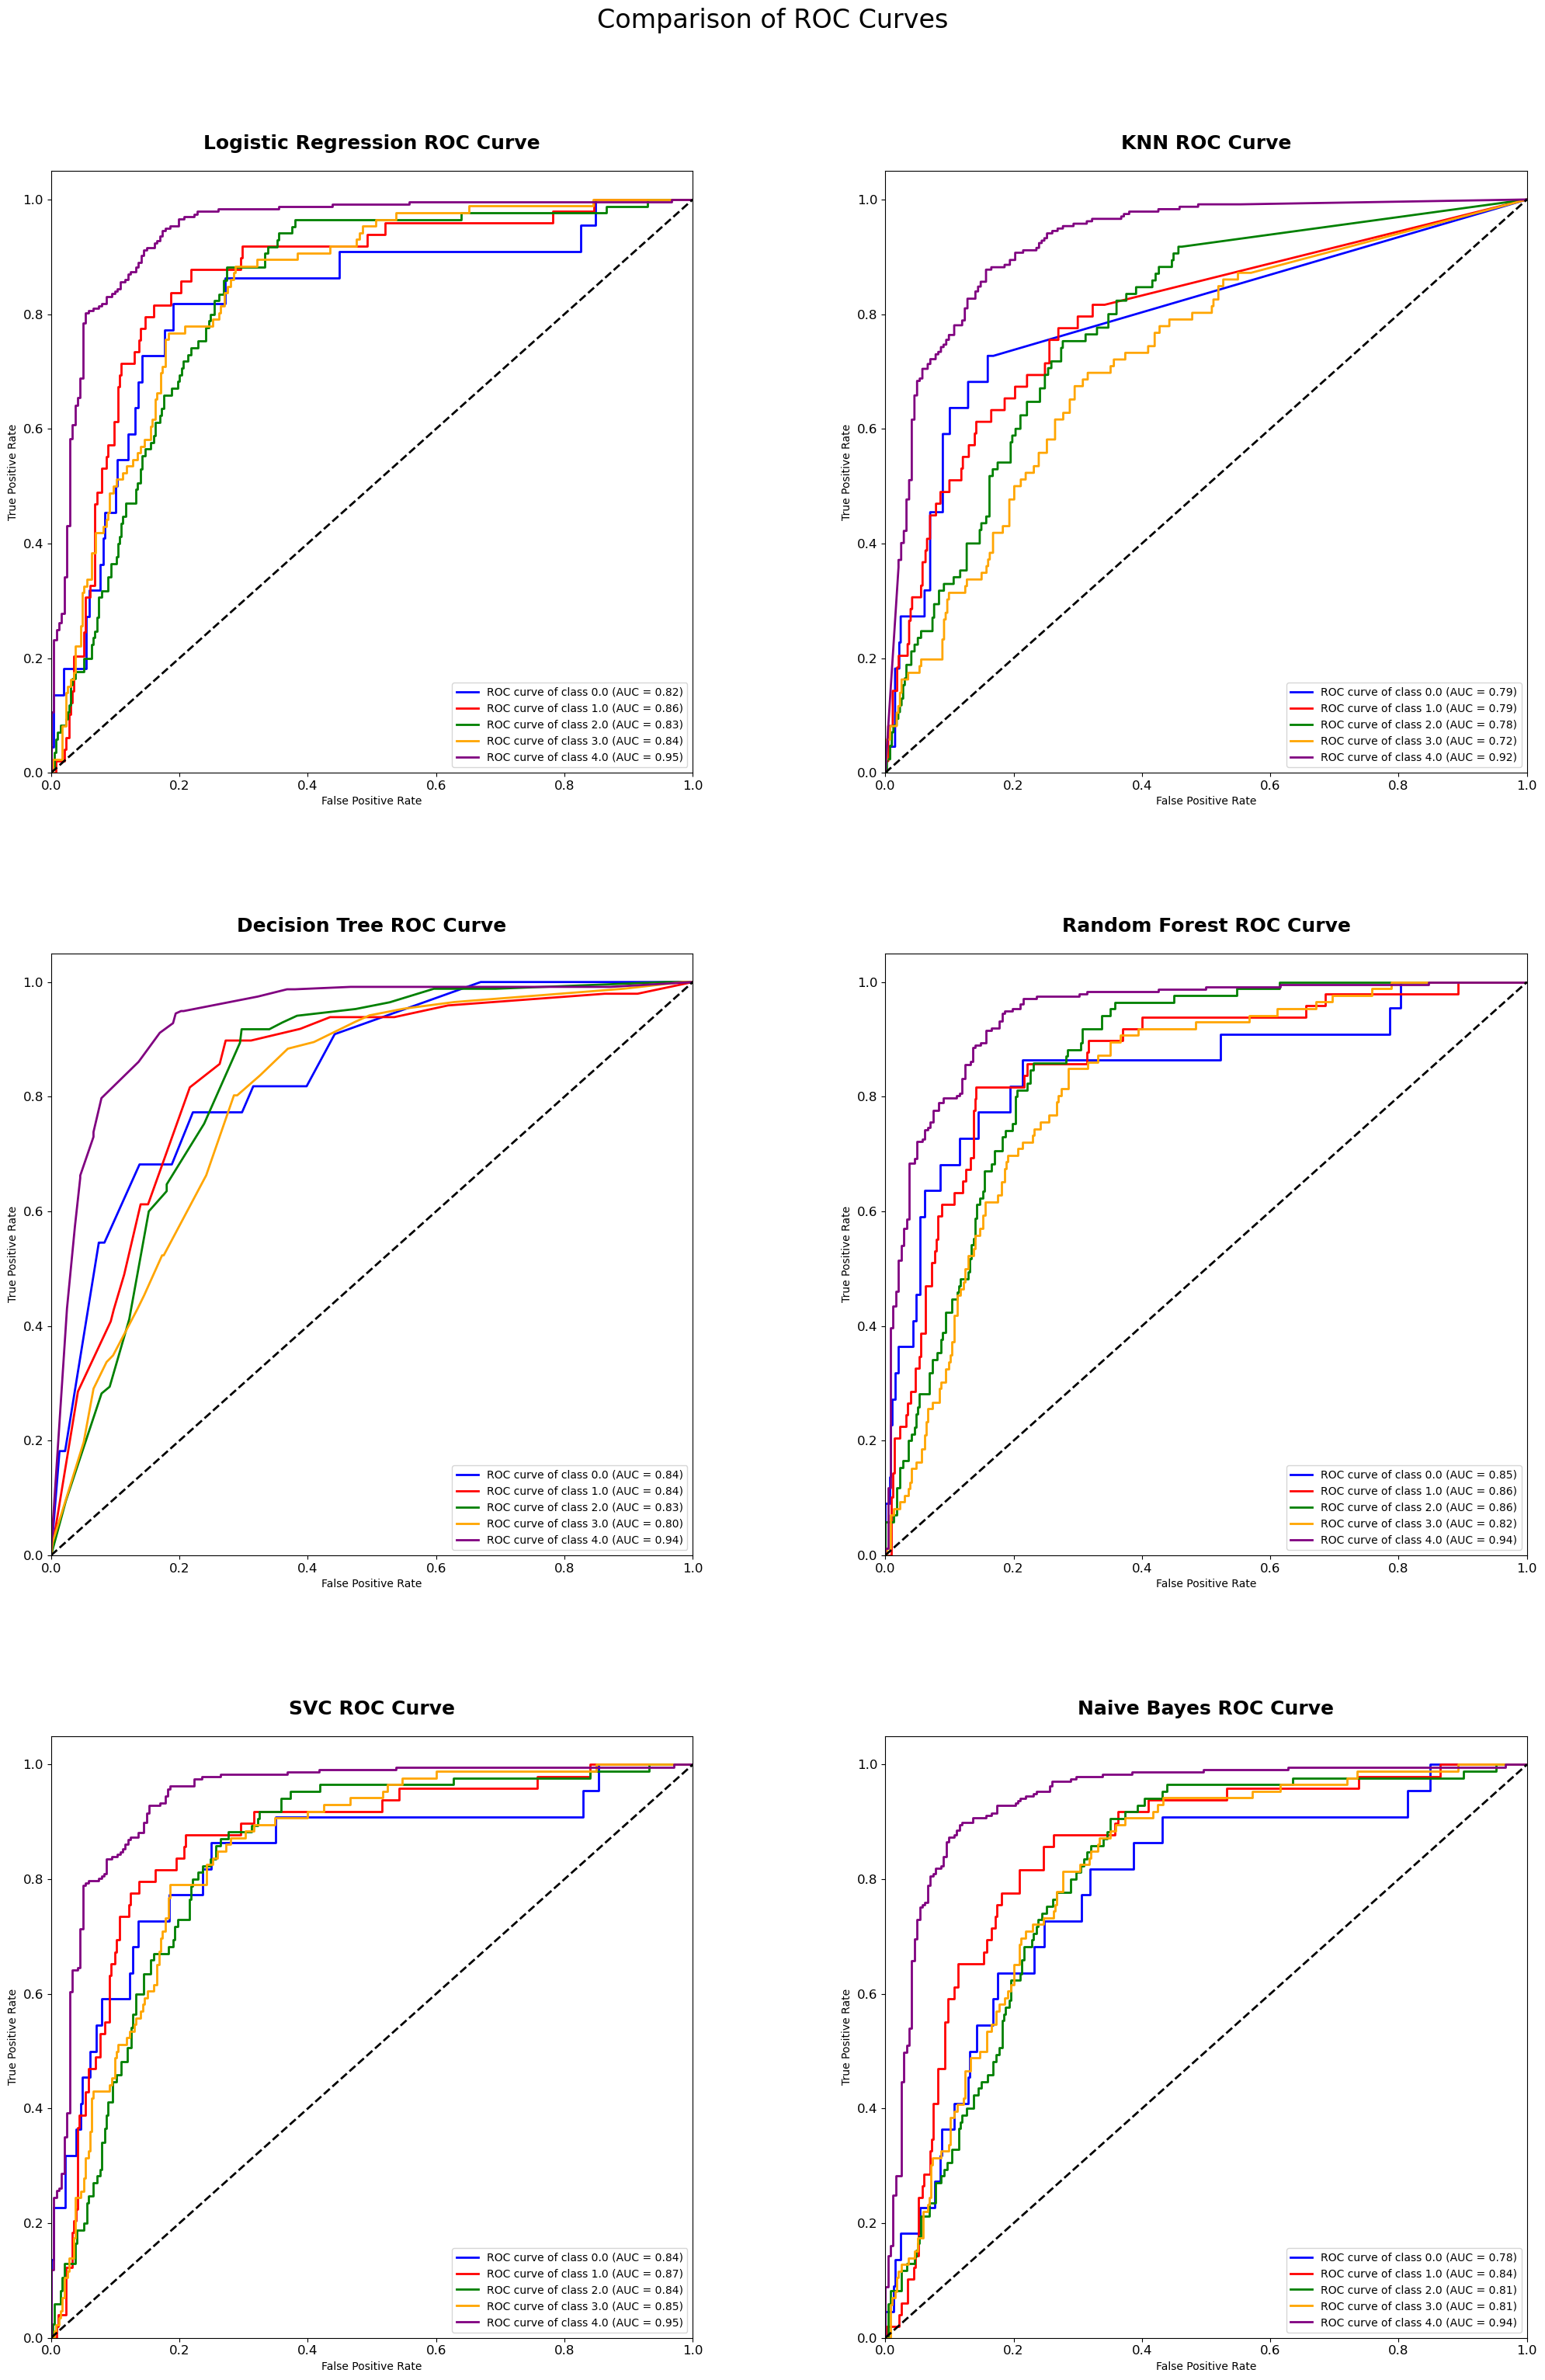

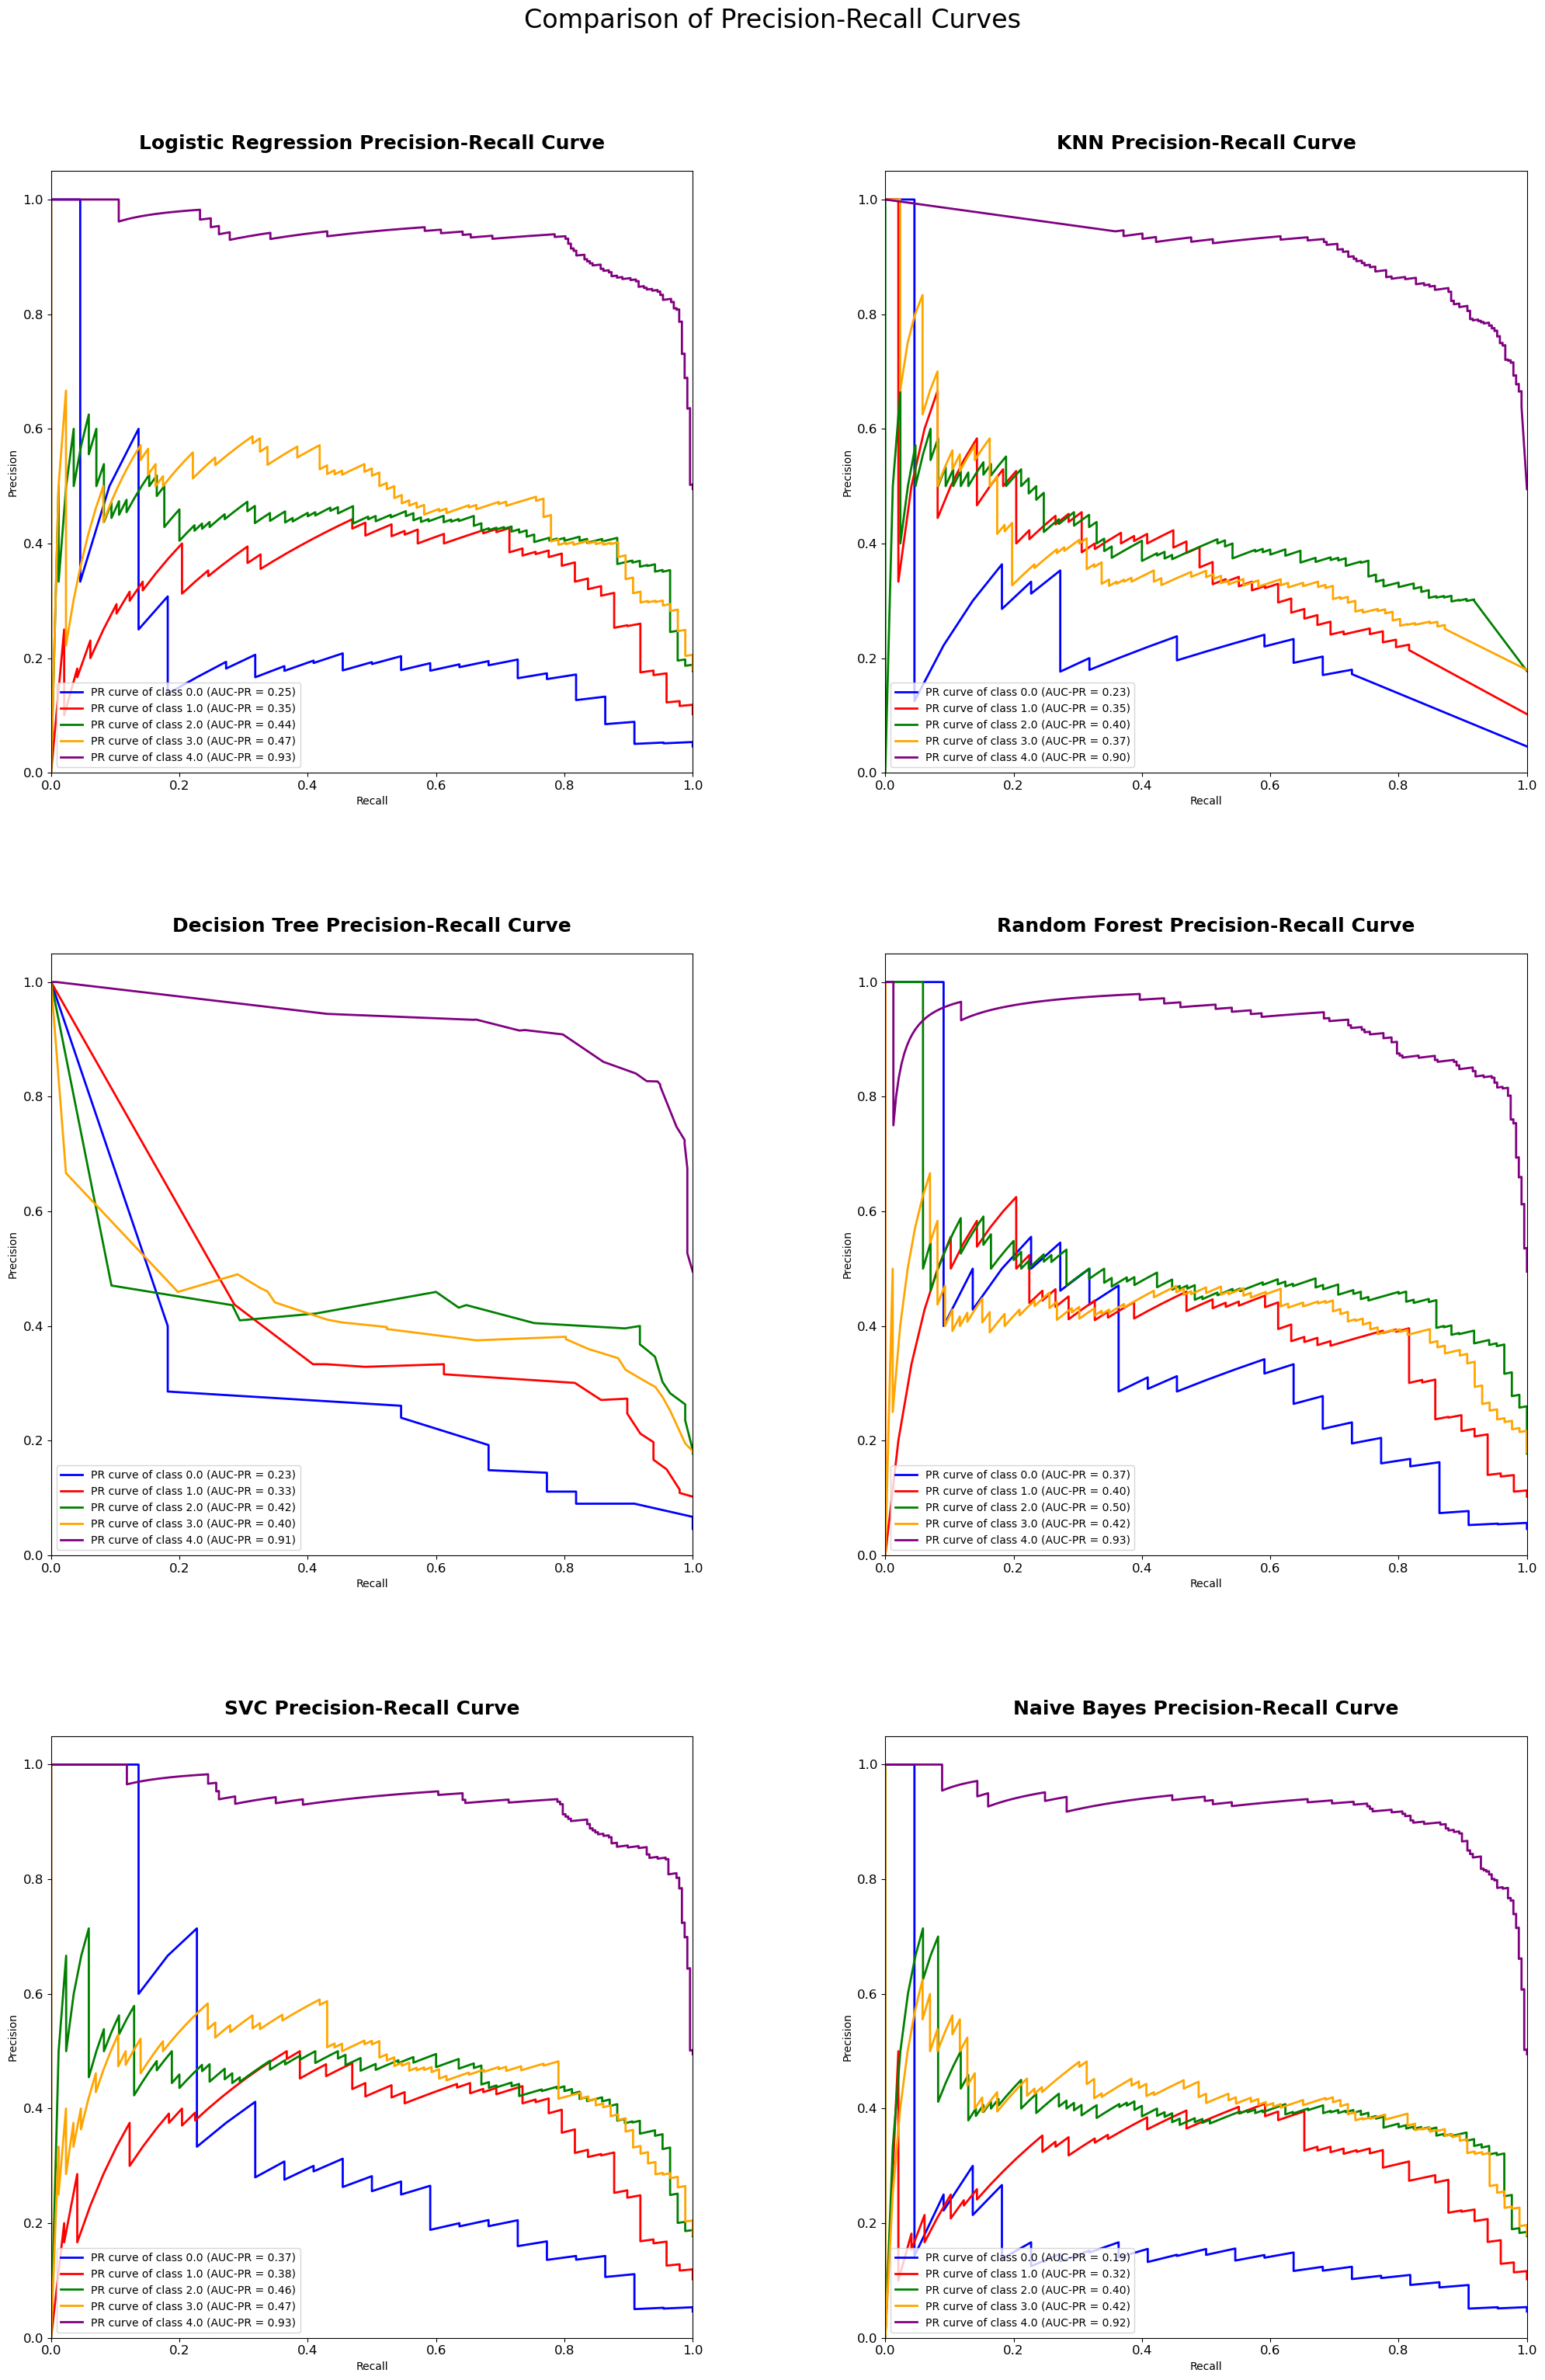

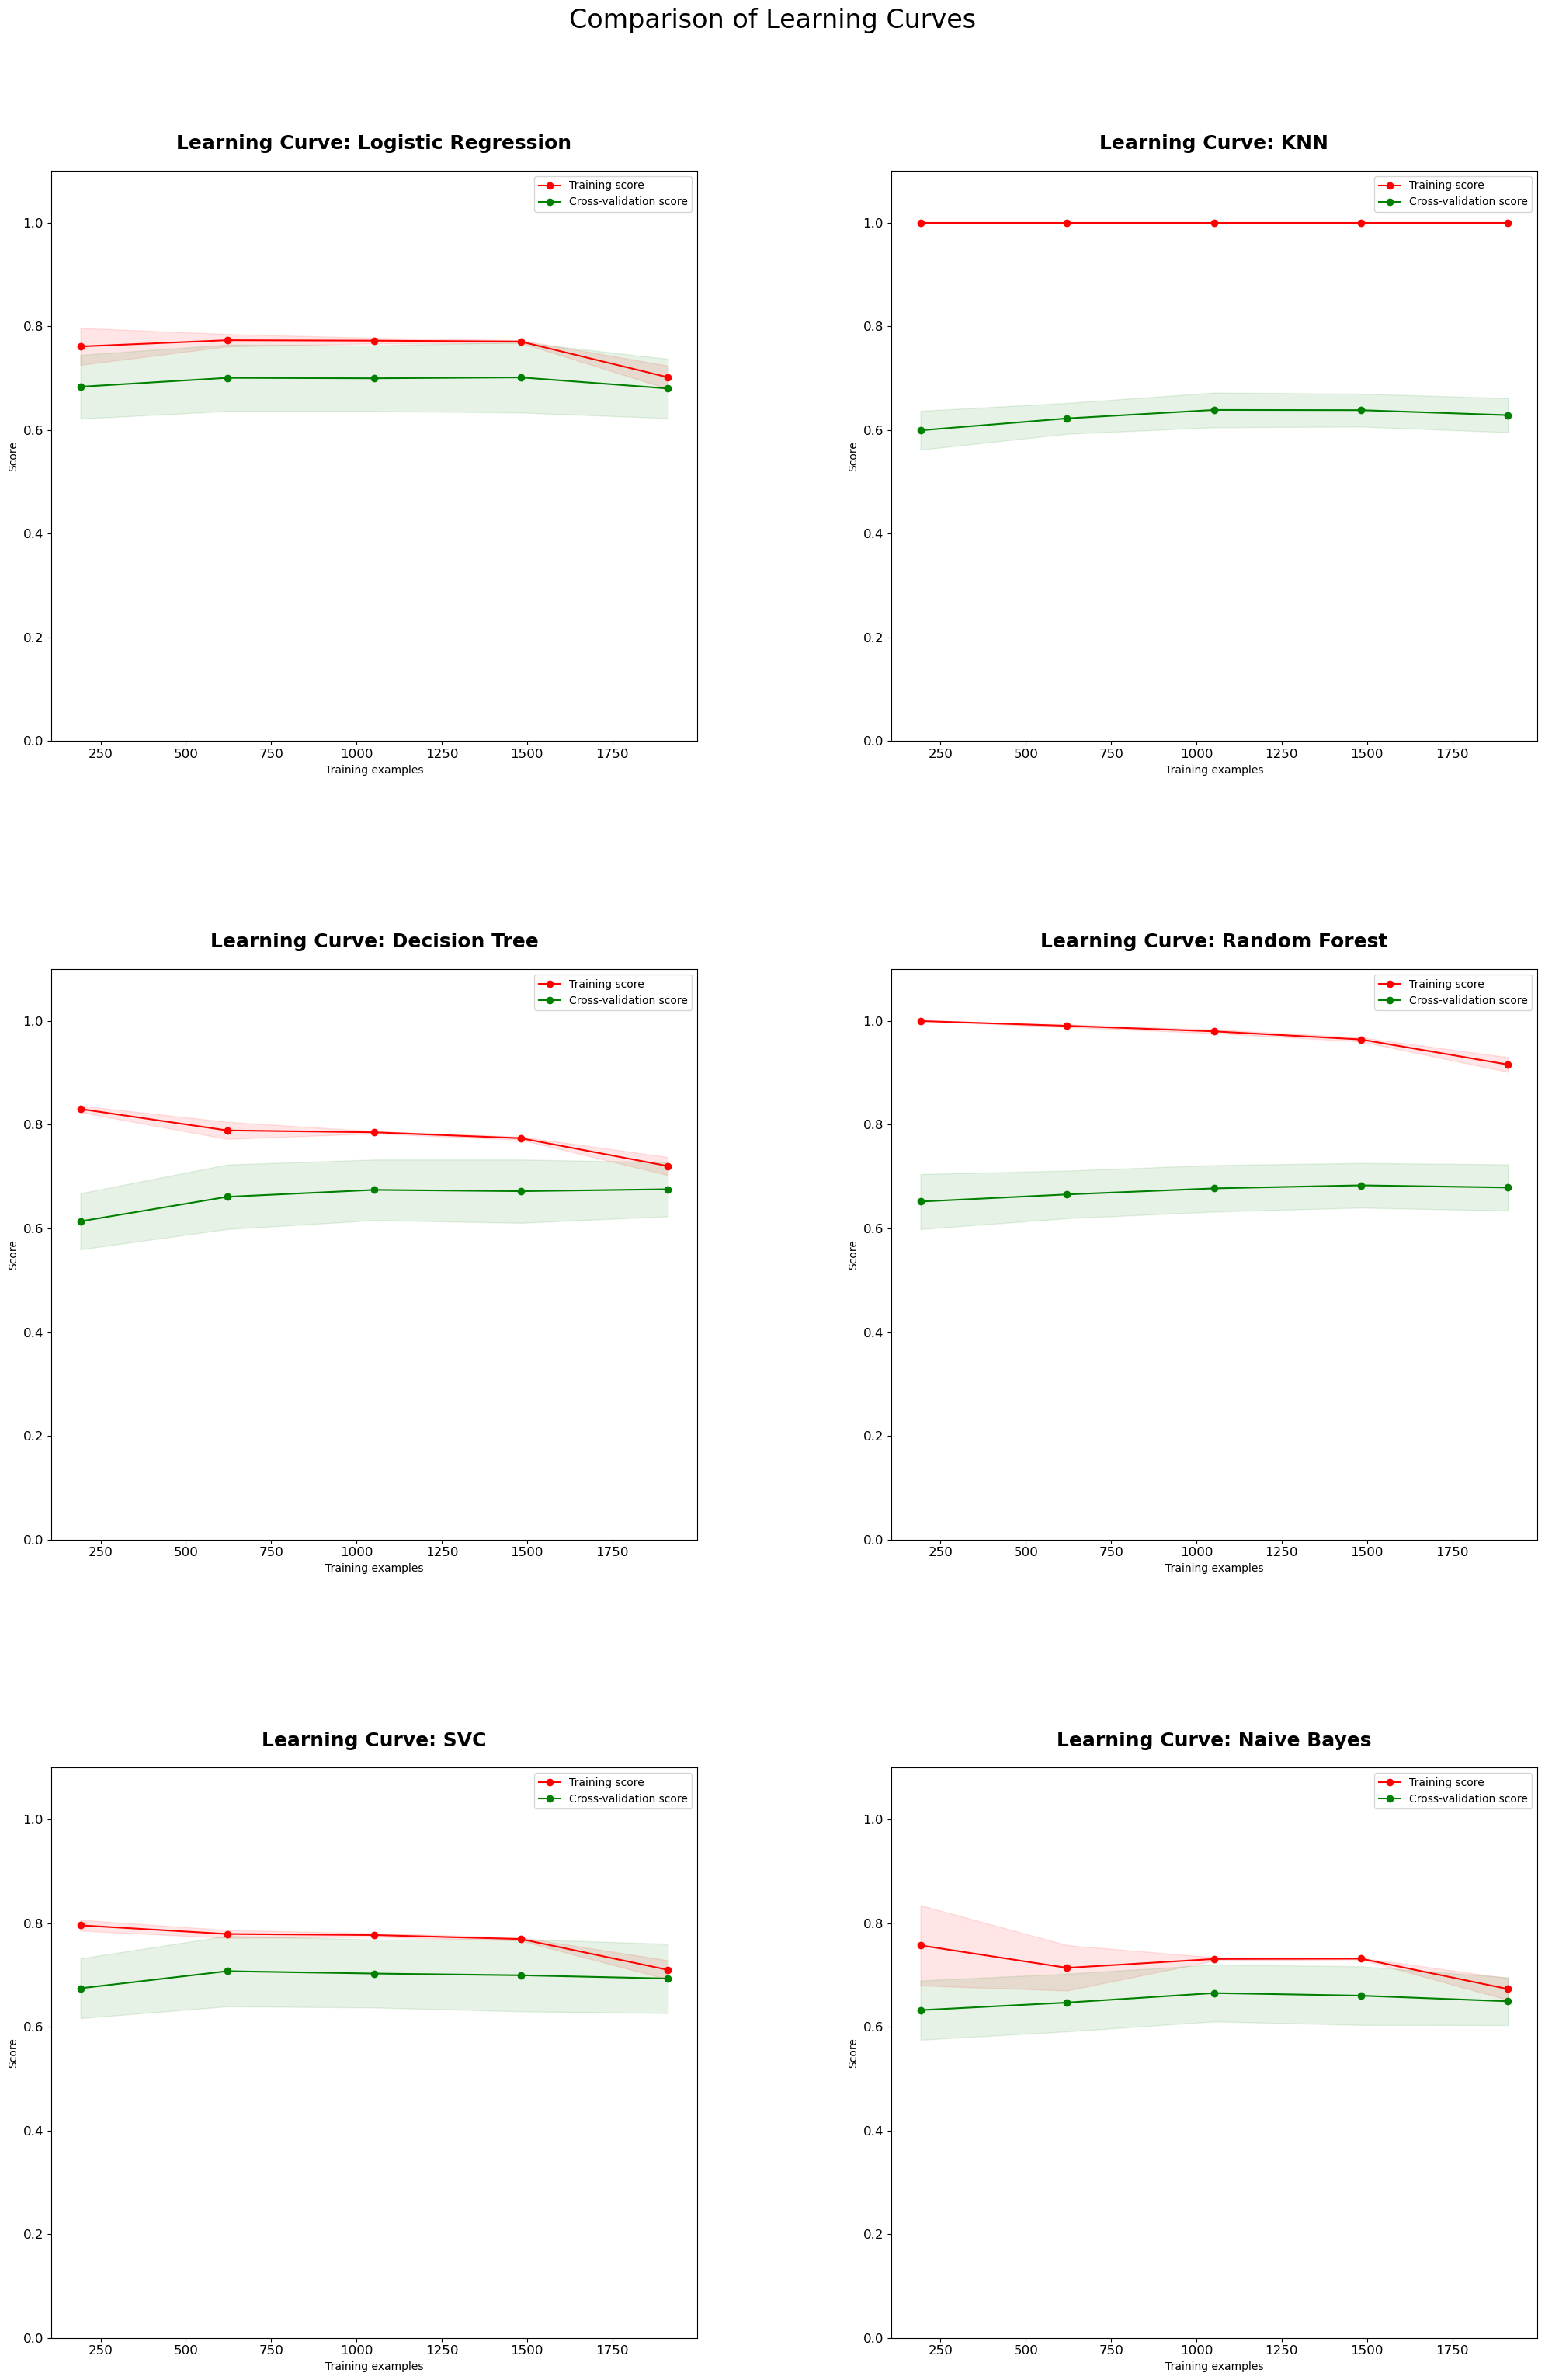

In [144]:
target_classes = nominal_target_preprocessor.classes_

def plot_confusion_matrices_comparison(model_results: dict[str, dict], y_test: np.ndarray, target_classes: np.ndarray):
    """
    Plots confusion matrices for multiple classification models in a grid layout.
    
    Args:
    model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
                                     and each value is a dictionary containing model predictions
    y_test (np.ndarray): Actual target values
    target_classes (np.ndarray): Array of target class names
    
    Returns:
    None
    """
    num_models = len(model_results)
    num_rows = math.ceil(num_models / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 10*num_rows))
    
    fig.suptitle('Comparison of Confusion Matrices', fontsize=24, y=1.02)
    
    axes_flat = axes.flatten() if num_models > 1 else [axes]
    
    for ax, (model_name, results) in zip(axes_flat, model_results.items()):
        y_pred = results['y_test_predictions']
        cm = confusion_matrix(y_test, y_pred)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
        disp.plot(ax=ax, cmap="Blues", values_format='d')
        
        ax.set_title(f'{model_name} Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Calculate and display accuracy
        accuracy = accuracy_score(y_test, y_pred)
        ax.text(0.5, -0.1, f'Accuracy: {accuracy:.3f}', 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize=14, fontweight='bold')
    
    for ax in axes_flat[num_models:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)
    plt.show()
    

def plot_roc_curves_comparison(model_results: dict[str, dict], y_test: np.ndarray, target_classes: np.ndarray):
    """
    Plots ROC curves for multiple classification models in a grid layout.
    
    Args:
    model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
                                     and each value is a dictionary containing model predictions
    y_test (np.ndarray): Actual target values
    target_classes (np.ndarray): Array of target class names
    
    Returns:
    None
    """
    num_models = len(model_results)
    num_rows = math.ceil(num_models / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 10*num_rows))
    
    fig.suptitle('Comparison of ROC Curves', fontsize=24, y=1.02)
    
    axes_flat = axes.flatten() if num_models > 1 else [axes]
    
    n_classes = len(target_classes)
    y_bin = label_binarize(y_test, classes=range(n_classes))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for ax, (model_name, results) in zip(axes_flat, model_results.items()):
        y_prediction_probabilities = results['y_test_prediction_probabilities']
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prediction_probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
            ax.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
                    label=f'ROC curve of class {target_classes[i]} (AUC = {roc_auc[i]:.2f})')
        
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{model_name} ROC Curve', fontsize=18, fontweight='bold', pad=20)
        ax.legend(loc="lower right", fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    for ax in axes_flat[num_models:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)
    plt.show()


def plot_precision_recall_curves_comparison(model_results: dict[str, dict], y_test: np.ndarray, target_classes: np.ndarray):
    """
    Plots Precision-Recall curves for multiple classification models in a grid layout.
    
    Args:
    model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
                                     and each value is a dictionary containing model predictions
    y_test (np.ndarray): Actual target values
    target_classes (np.ndarray): Array of target class names
    
    Returns:
    None
    """
    num_models = len(model_results)
    num_rows = math.ceil(num_models / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 10*num_rows))
    
    fig.suptitle('Comparison of Precision-Recall Curves', fontsize=24, y=1.02)
    
    axes_flat = axes.flatten() if num_models > 1 else [axes]
    
    n_classes = len(target_classes)
    y_bin = label_binarize(y_test, classes=range(n_classes))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for ax, (model_name, results) in zip(axes_flat, model_results.items()):
        y_prediction_probabilities = results['y_test_prediction_probabilities']
        
        precision = dict()
        recall = dict()
        avg_precision = dict()
        
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_prediction_probabilities[:, i])
            avg_precision[i] = average_precision_score(y_bin[:, i], y_prediction_probabilities[:, i])
            
            ax.plot(recall[i], precision[i], color=colors[i % len(colors)], lw=2,
                    label=f'PR curve of class {target_classes[i]} (AUC-PR = {avg_precision[i]:.2f})')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{model_name} Precision-Recall Curve', fontsize=18, fontweight='bold', pad=20)
        ax.legend(loc="lower left", fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    for ax in axes_flat[num_models:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)
    plt.show()
    

def plot_learning_curves_comparison(model_results: dict[str, dict], X: np.ndarray, y: np.ndarray):
    """
    Plots learning curves for multiple classification models in a grid layout.
    
    Args:
    model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
                                     and each value is a dictionary containing the trained model
    X (np.ndarray): Feature matrix
    y (np.ndarray): Target vector
    
    Returns:
    None
    """
    num_models = len(model_results)
    num_rows = math.ceil(num_models / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 10*num_rows))
    
    fig.suptitle('Comparison of Learning Curves', fontsize=24, y=1.02)
    
    axes_flat = axes.flatten() if num_models > 1 else [axes]
    
    for ax, (model_name, results) in zip(axes_flat, model_results.items()):
        estimator = results['best_model']
        
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=5, n_jobs=-1, 
            train_sizes=np.linspace(.1, 1.0, 5))
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        ax.set_title(f"Learning Curve: {model_name}", fontsize=18, fontweight='bold', pad=20)
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")
        ax.fill_between(train_sizes, (train_scores_mean - train_scores_std),
                        (train_scores_mean + train_scores_std), alpha=0.1, color="r")
        ax.fill_between(train_sizes, (test_scores_mean - test_scores_std),
                        (test_scores_mean + test_scores_std), alpha=0.1, color="g")
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax.legend(loc="best")
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Set y-axis limits
        ax.set_ylim(0, 1.1)
    
    for ax in axes_flat[num_models:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.3)
    plt.show()
    

plot_confusion_matrices_comparison(model_results, y_test, target_classes)
plot_roc_curves_comparison(model_results, y_test, target_classes)
plot_precision_recall_curves_comparison(model_results, y_test, target_classes)
plot_learning_curves_comparison(model_results, X, y)

## **Individual Model Performance Visualizations**

### **Plotting Functions**

In [148]:

def display_model_evaluation_results(model_name: str, results: dict = model_results) -> None:
    """
    Displays the evaluation results for a given model.
    
    Args:
        model_name (str): Name of the model
        results (dict): Dictionary containing the evalutation results of each model
    Returns: None
    """
    display_markdown(md(f"### **Model: {model_name}**"))
    display_markdown(md(f"* #### **F1 Score:** {results[model_name]["f1"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Accuracy:** {results[model_name]["accuracy"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Precision:** {results[model_name]["precision"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Recall:** {results[model_name]["recall"]:.{NUM_DECIMAL_PLACES}f}"))



def plot_confusion_matrix(model_name, y_true, y_predictions, classes = target_classes):
    cm = confusion_matrix(y_true, y_predictions)
    plt.figure(figsize = (12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
    disp.plot(cmap = "Blues")
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    
def plot_roc_curve(model_name, y_true, y_prediction_probabilities, classes = target_classes):
    n_classes = len(classes)
    y_bin = label_binarize(y_true, classes = range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prediction_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    plt.figure(figsize = (10, 8))
    for i, color in zip(range(n_classes), ['blue', 'red', 'green', 'orange']):
        plt.plot(fpr[i], tpr[i], color = color, lw = 2,
                 label = f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = "lower right")
    plt.show()
    
    
def plot_multiclass_precision_recall_curve(model_name, y_true, y_prediction_probabilities, classes = target_classes):
    n_classes = len(classes)
    y_bin = label_binarize(y_true, classes = range(n_classes))
    
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_prediction_probabilities[:, i])
        avg_precision[i] = average_precision_score(y_bin[:, i], y_prediction_probabilities[:, i])
    
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), ['blue', 'red', 'green', 'orange']):
        plt.plot(recall[i], precision[i], color = color, lw = 2,
                 label = f'Precision-Recall curve of class {classes[i]} (AUC = {avg_precision[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc = "lower left")
    plt.show()
    

feature_columns = list(X_train.columns)
def get_featuere_names(X_column_names = feature_columns):
    feature_names = [column_name.replace("_", " ") for column_name in X_column_names]
    return feature_names


def plot_feature_importance(model_name, model, feature_names = FEATURE_LIST):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"{model_name} Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation = 90)
    plt.tight_layout()
    plt.show()
    

def plot_learning_curve(estimator, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes = np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, (train_scores_mean - train_scores_std),
                     (train_scores_mean + train_scores_std), alpha = 0.1, color = "r")
    plt.fill_between(train_sizes, (test_scores_mean - test_scores_std),
                     (test_scores_mean + test_scores_std), alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "Cross-validation score")
    plt.legend(loc = "best")
    plt.show()

### **Logistic Regression**

In [149]:
logistic_model_name = "Logistic Regression"

logistic_best_model = model_results[logistic_model_name]["best_model"]

logistic_y_test_predictions = model_results[logistic_model_name]["y_test_predictions"]
logistic_y_test_prediction_probabilities = model_results[logistic_model_name]["y_test_prediction_probabilities"]

logistic_f1_score = model_results[logistic_model_name]["f1"]
logistic_accuracy = model_results[logistic_model_name]["accuracy"]
logistic_precision = model_results[logistic_model_name]["precision"]
logistic_recall = model_results[logistic_model_name]["recall"]

### **Model: Logistic Regression**

* #### **F1 Score:** 0.6359361

* #### **Accuracy:** 0.6659708

* #### **Precision:** 0.6219152

* #### **Recall:** 0.6659708

<Figure size 1200x800 with 0 Axes>

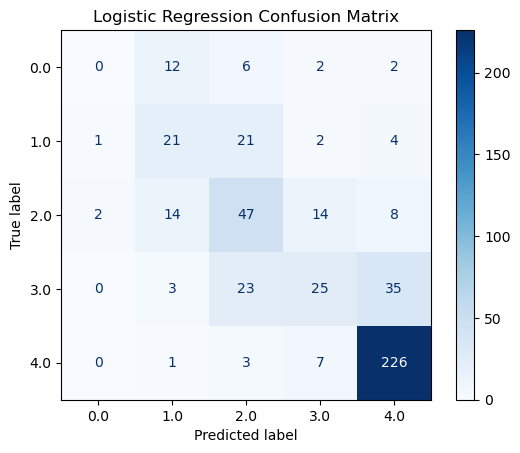

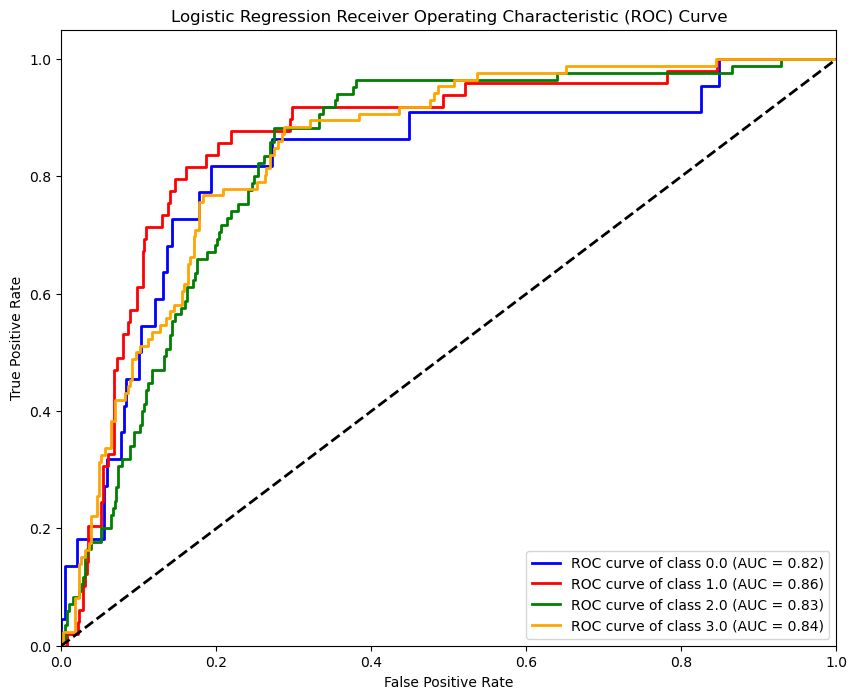

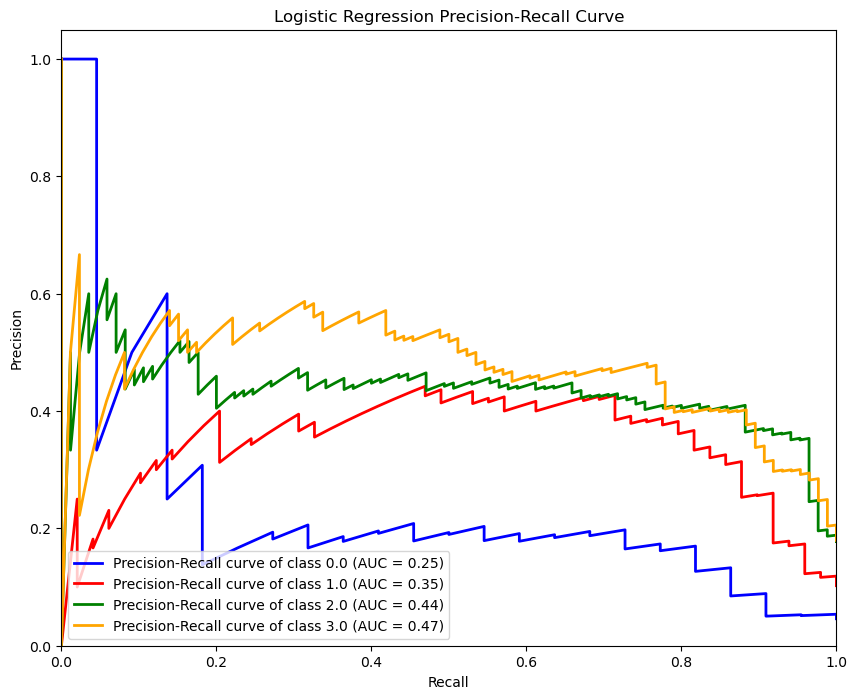

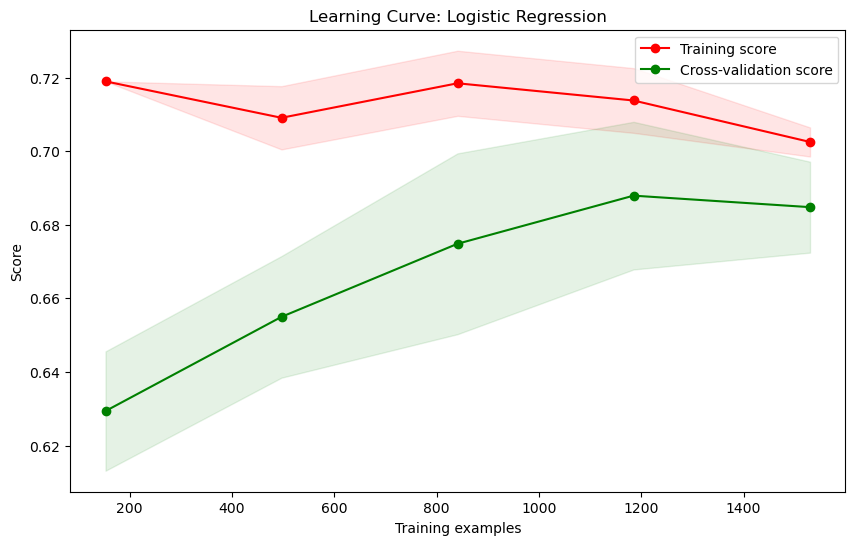

In [150]:
display_model_evaluation_results(logistic_model_name)
plot_confusion_matrix(logistic_model_name, y_test, logistic_y_test_predictions)
plot_roc_curve(logistic_model_name, y_test, logistic_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(logistic_model_name, y_test, logistic_y_test_prediction_probabilities)
plot_learning_curve(logistic_best_model, X_train, y_train, logistic_model_name)

In [152]:
knn_model_name = "KNN"

knn_best_model = model_results[knn_model_name]["best_model"]

knn_y_test_predictions = model_results[knn_model_name]["y_test_predictions"]
knn_y_test_prediction_probabilities = model_results[knn_model_name]["y_test_prediction_probabilities"]

knn_f1_score = model_results[knn_model_name]["f1"]
knn_accuracy = model_results[knn_model_name]["accuracy"]
knn_precision = model_results[knn_model_name]["precision"]
knn_recall = model_results[knn_model_name]["recall"]

### **Model: KNN**

* #### **F1 Score:** 0.5932705

* #### **Accuracy:** 0.6137787

* #### **Precision:** 0.5809965

* #### **Recall:** 0.6137787

<Figure size 1200x800 with 0 Axes>

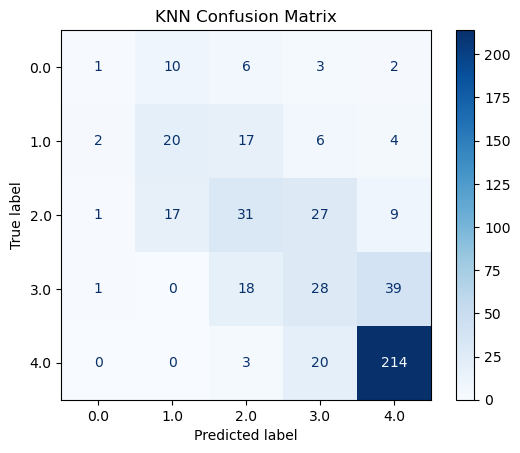

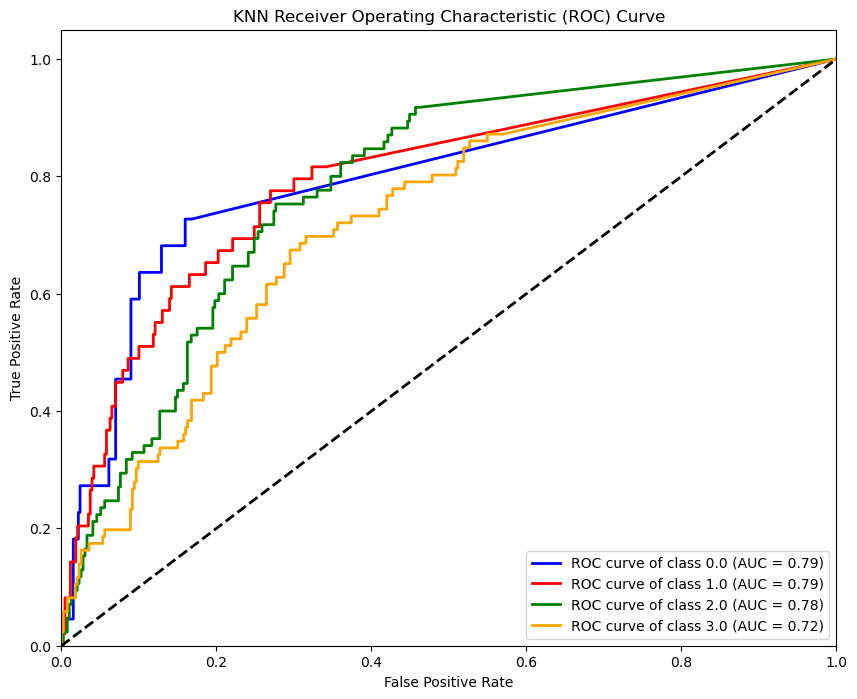

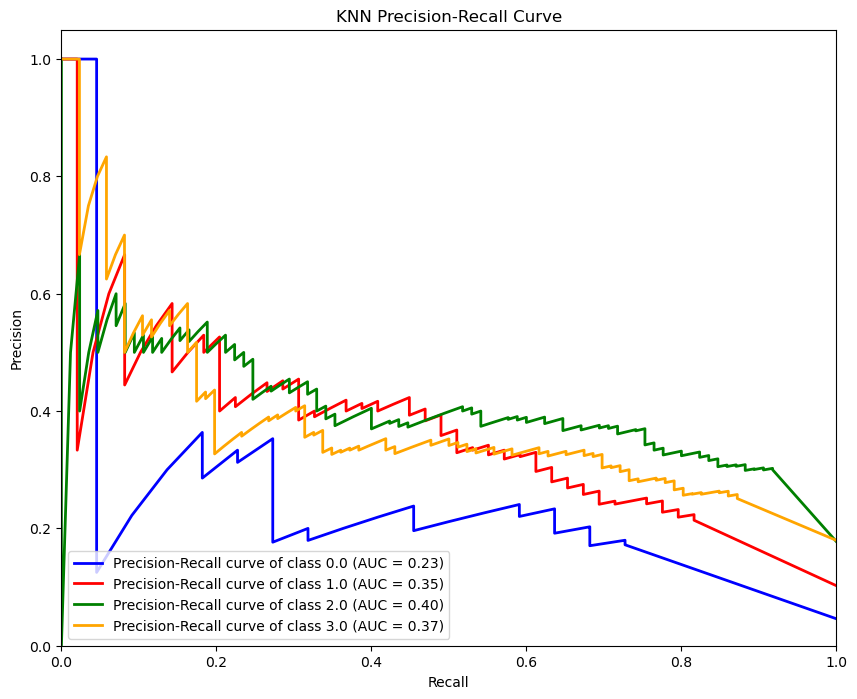

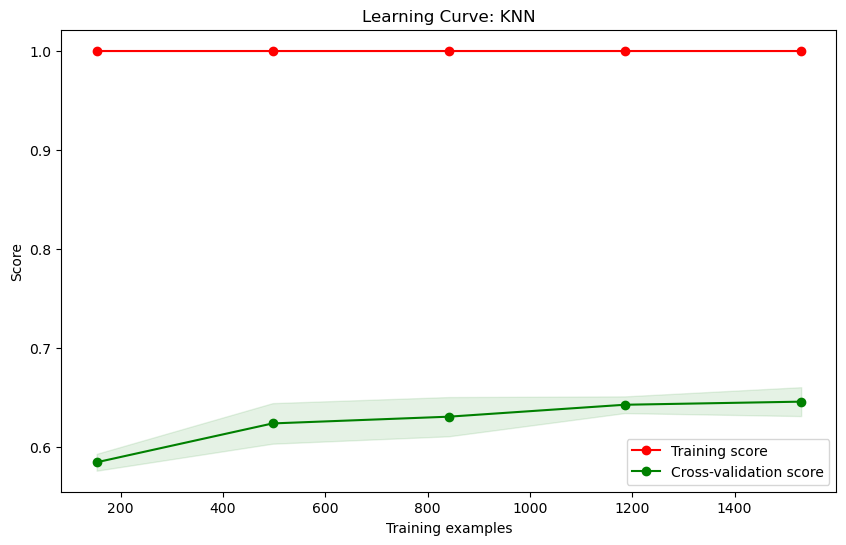

In [153]:
display_model_evaluation_results(knn_model_name)
plot_confusion_matrix(knn_model_name, y_test, knn_y_test_predictions)
plot_roc_curve(knn_model_name, y_test, knn_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(knn_model_name, y_test, knn_y_test_prediction_probabilities)
plot_learning_curve(knn_best_model, X_train, y_train, knn_model_name)

In [155]:
decision_tree_model_name = "Decision Tree"

decision_tree_best_model = model_results[decision_tree_model_name]["best_model"]

decision_tree_y_test_predictions = model_results[decision_tree_model_name]["y_test_predictions"]
decision_tree_y_test_prediction_probabilities = model_results[decision_tree_model_name]["y_test_prediction_probabilities"]

decision_tree_f1_score = model_results[decision_tree_model_name]["f1"]
decision_tree_accuracy = model_results[decision_tree_model_name]["accuracy"]
decision_tree_precision = model_results[decision_tree_model_name]["precision"]
decision_tree_recall = model_results[decision_tree_model_name]["recall"]

### **Model: Decision Tree**

* #### **F1 Score:** 0.6250797

* #### **Accuracy:** 0.6367432

* #### **Precision:** 0.6215795

* #### **Recall:** 0.6367432

<Figure size 1200x800 with 0 Axes>

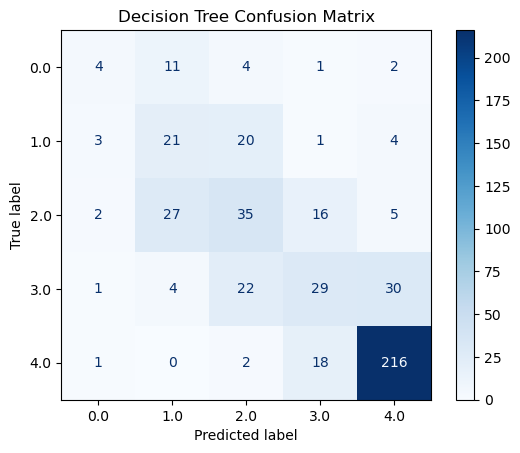

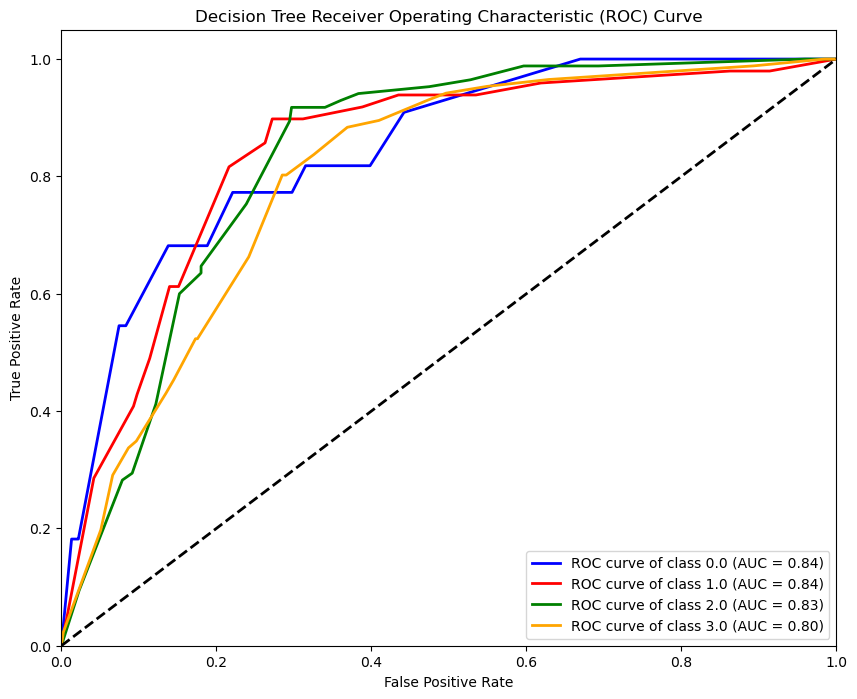

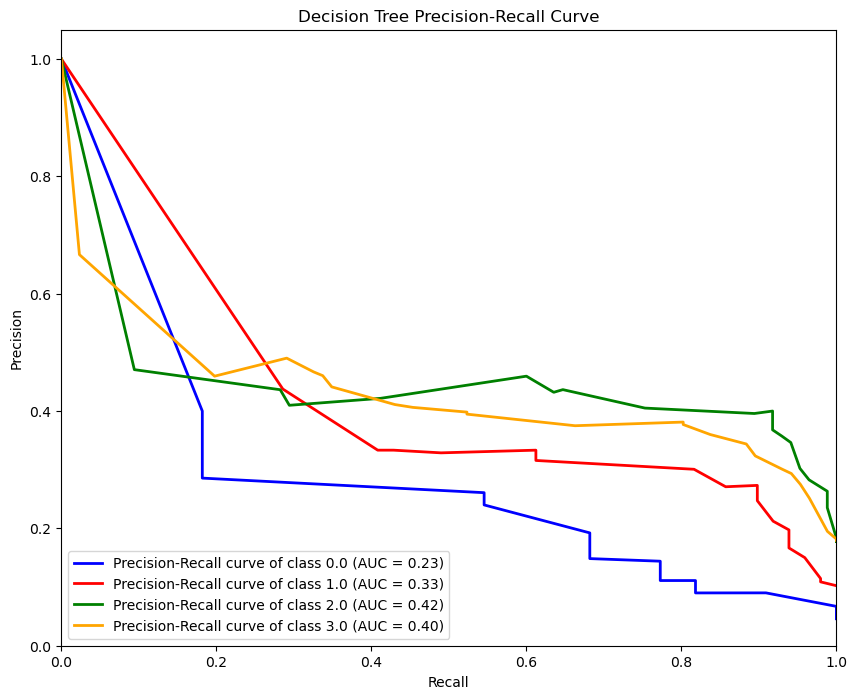

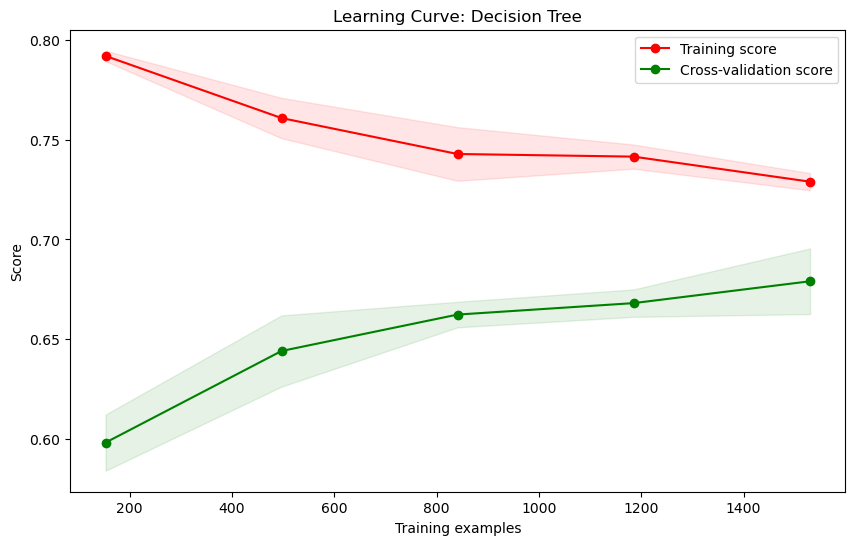

In [156]:
display_model_evaluation_results(decision_tree_model_name)
plot_confusion_matrix(decision_tree_model_name, y_test, decision_tree_y_test_predictions)
plot_roc_curve(decision_tree_model_name, y_test, decision_tree_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(decision_tree_model_name, y_test, decision_tree_y_test_prediction_probabilities)
plot_learning_curve(decision_tree_best_model, X_train, y_train, decision_tree_model_name)

In [157]:
random_forest_model_name = "Random Forest"

random_forest_best_model = model_results[random_forest_model_name]["best_model"]

random_forest_y_test_predictions = model_results[random_forest_model_name]["y_test_predictions"]
random_forest_y_test_prediction_probabilities = model_results[random_forest_model_name]["y_test_prediction_probabilities"]

random_forest_f1_score = model_results[random_forest_model_name]["f1"]
random_forest_accuracy = model_results[random_forest_model_name]["accuracy"]
random_forest_precision = model_results[random_forest_model_name]["precision"]
random_forest_recall = model_results[random_forest_model_name]["recall"]

### **Model: Random Forest**

* #### **F1 Score:** 0.6397976

* #### **Accuracy:** 0.6617954

* #### **Precision:** 0.6631739

* #### **Recall:** 0.6617954

<Figure size 1200x800 with 0 Axes>

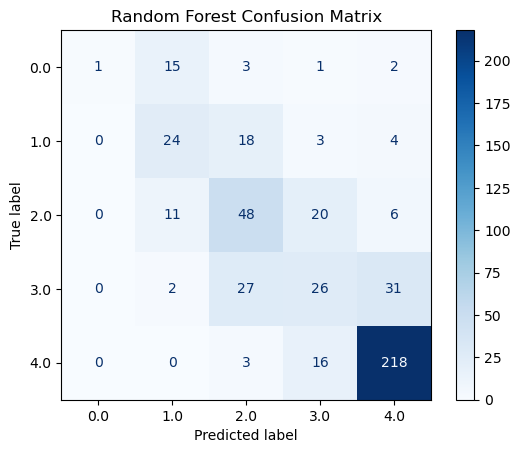

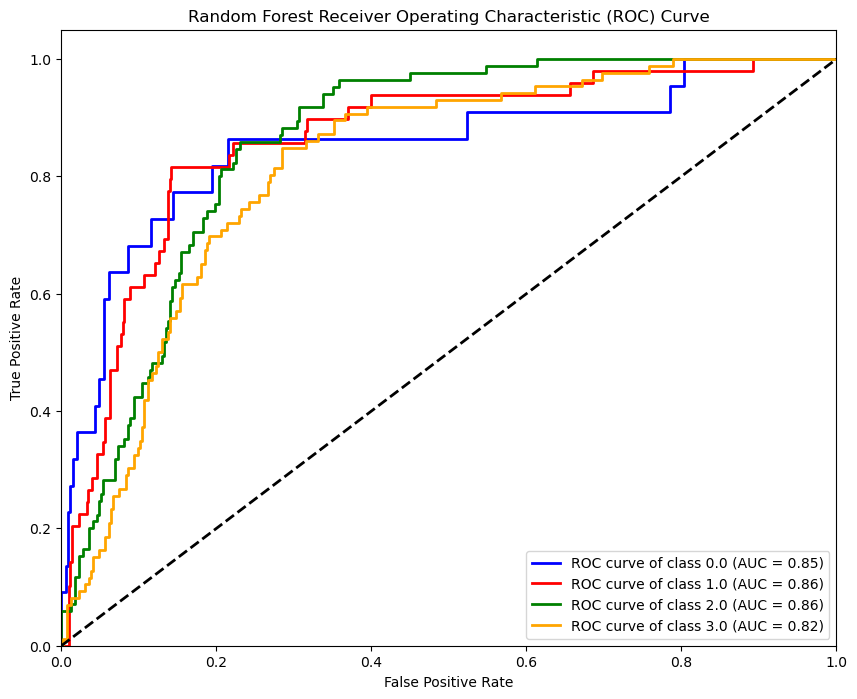

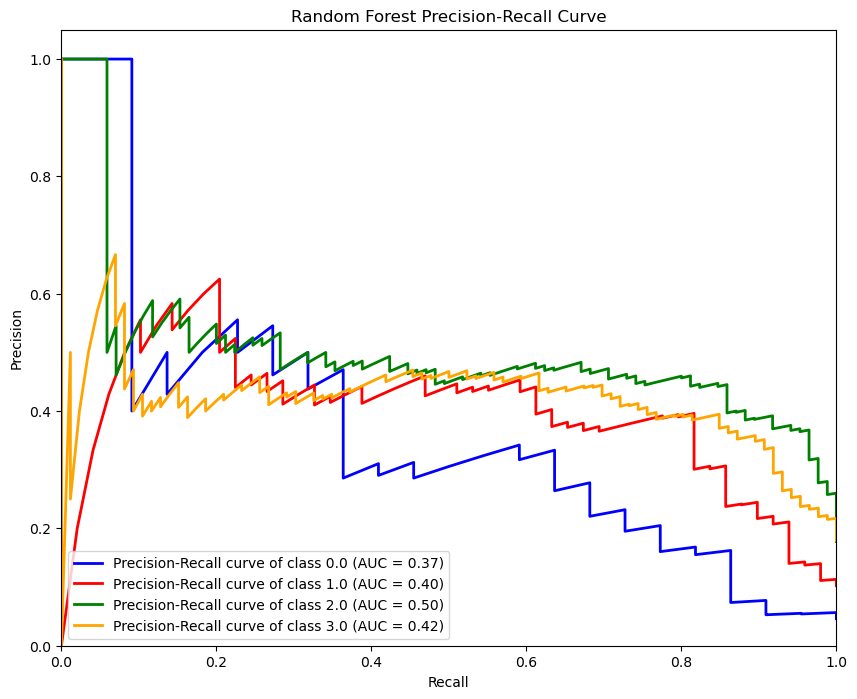

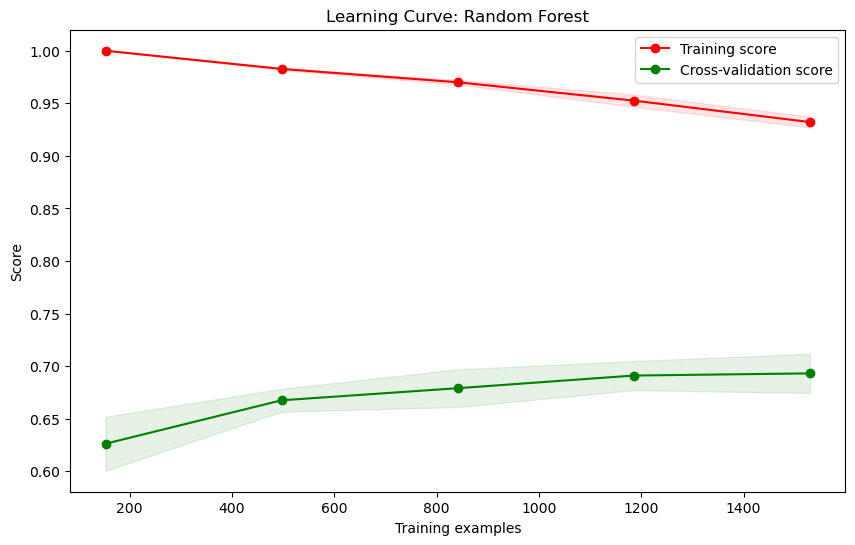

In [158]:
display_model_evaluation_results(random_forest_model_name)
plot_confusion_matrix(random_forest_model_name, y_test, random_forest_y_test_predictions)
plot_roc_curve(random_forest_model_name, y_test, random_forest_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(random_forest_model_name, y_test, random_forest_y_test_prediction_probabilities)
plot_learning_curve(random_forest_best_model, X_train, y_train, random_forest_model_name)

In [159]:
svc_model_name = "SVC"

svc_best_model = model_results[svc_model_name]["best_model"]

svc_y_test_predictions = model_results[svc_model_name]["y_test_predictions"]
svc_y_test_prediction_probabilities = model_results[svc_model_name]["y_test_prediction_probabilities"]

svc_f1_score = model_results[svc_model_name]["f1"]
svc_accuracy = model_results[svc_model_name]["accuracy"]
svc_precision = model_results[svc_model_name]["precision"]
svc_recall = model_results[svc_model_name]["recall"]

### **Model: SVC**

* #### **F1 Score:** 0.6791633

* #### **Accuracy:** 0.6993737

* #### **Precision:** 0.6631010

* #### **Recall:** 0.6993737

<Figure size 1200x800 with 0 Axes>

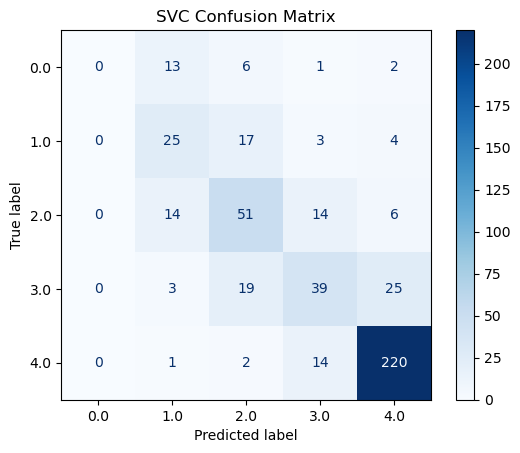

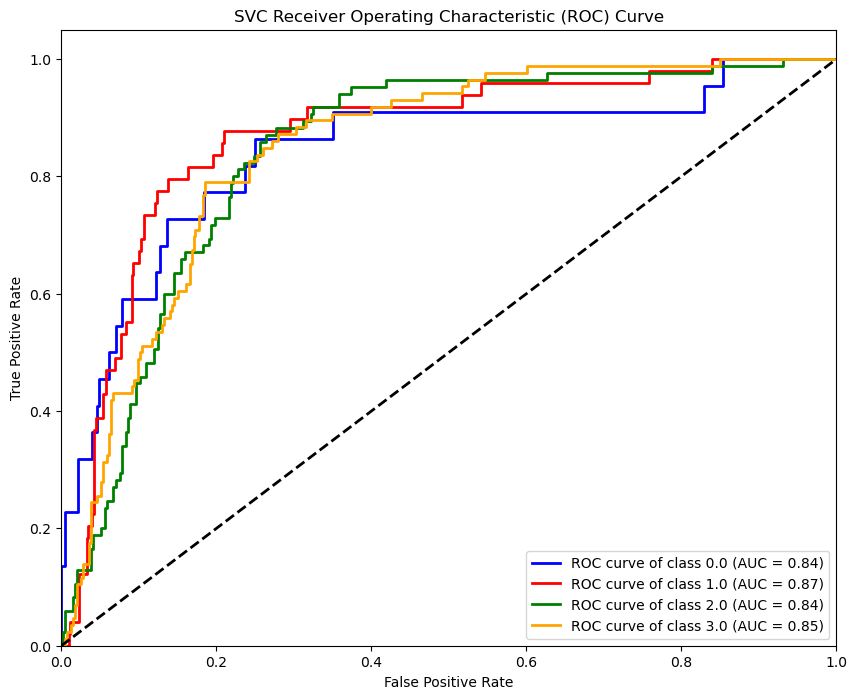

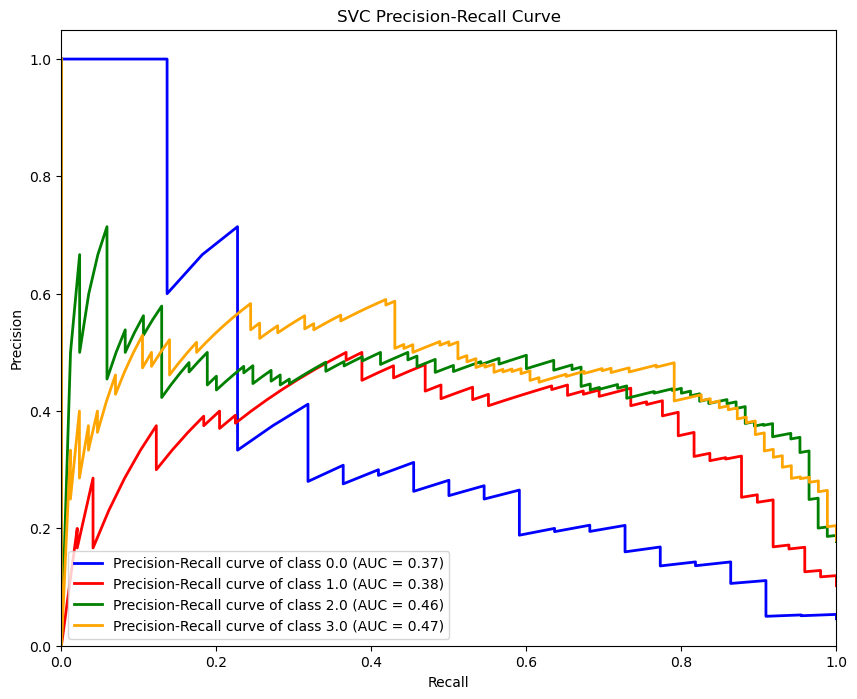

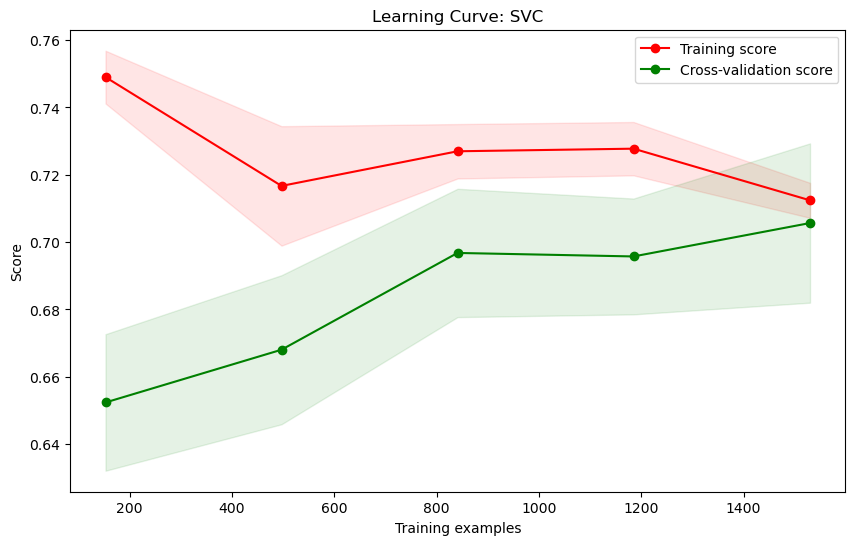

In [160]:
display_model_evaluation_results(svc_model_name)
plot_confusion_matrix(svc_model_name, y_test, svc_y_test_predictions)
plot_roc_curve(svc_model_name, y_test, svc_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(svc_model_name, y_test, svc_y_test_prediction_probabilities)
plot_learning_curve(svc_best_model, X_train, y_train, svc_model_name)

In [161]:
naive_bayes_model_name = "Naive Bayes"

naive_bayes_best_model = model_results[naive_bayes_model_name]["best_model"]

naive_bayes_y_test_predictions = model_results[naive_bayes_model_name]["y_test_predictions"]
naive_bayes_y_test_prediction_probabilities = model_results[naive_bayes_model_name]["y_test_prediction_probabilities"]

naive_bayes_f1_score = model_results[naive_bayes_model_name]["f1"]
naive_bayes_accuracy = model_results[naive_bayes_model_name]["accuracy"]
naive_bayes_precision = model_results[naive_bayes_model_name]["precision"]
naive_bayes_recall = model_results[naive_bayes_model_name]["recall"]

### **Model: Naive Bayes**

* #### **F1 Score:** 0.6050481

* #### **Accuracy:** 0.6325678

* #### **Precision:** 0.6011749

* #### **Recall:** 0.6325678

<Figure size 1200x800 with 0 Axes>

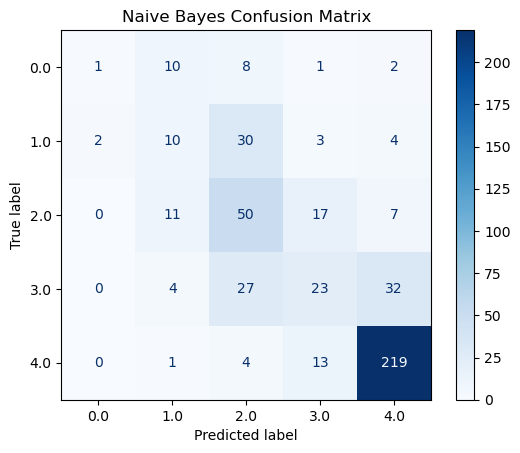

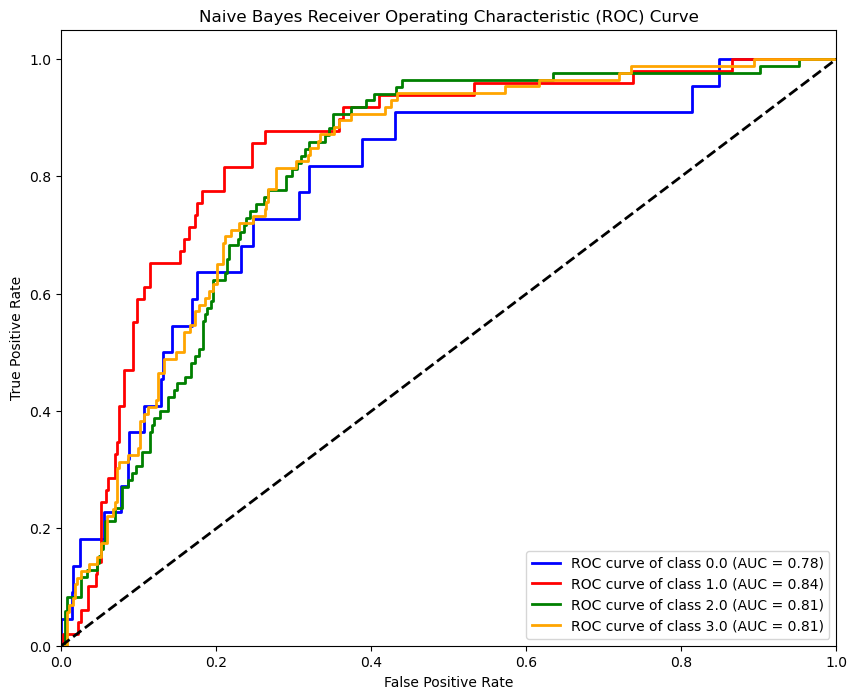

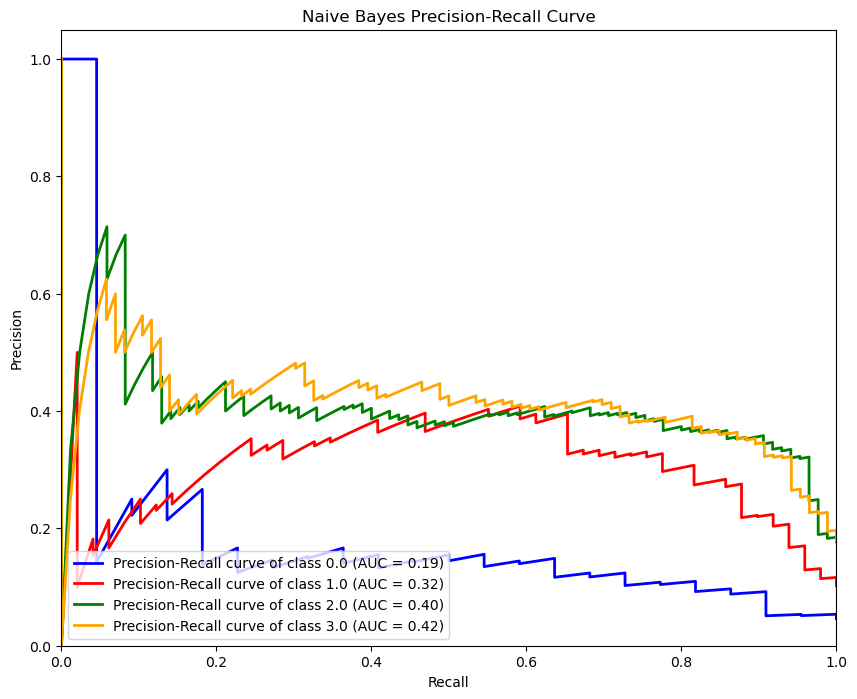

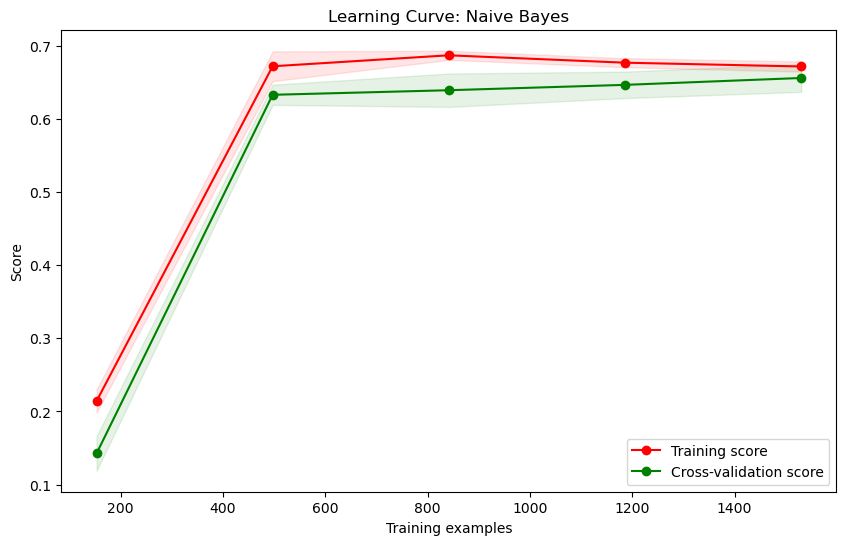

In [162]:
display_model_evaluation_results(naive_bayes_model_name)
plot_confusion_matrix(naive_bayes_model_name, y_test, naive_bayes_y_test_predictions)
plot_roc_curve(naive_bayes_model_name, y_test, naive_bayes_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(naive_bayes_model_name, y_test, naive_bayes_y_test_prediction_probabilities)
plot_learning_curve(naive_bayes_best_model, X_train, y_train, naive_bayes_model_name)